## WGU D599: Data Preparation and Exploration
#### John D. Pickering

In [1]:
# import dependencies
import json
import csv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast
import numpy as np
import plotly
from scipy.stats import zscore
import seaborn as sns
from collections import Counter
import re
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read dataset into pandas as df
df = pd.read_csv('Employee Turnover Dataset.csv', low_memory=False)

In [3]:
# A1 - Identify the number of records and variables (columns)
# Rows: 10199
# Columns: 16
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10199 entries, 0 to 10198
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   EmployeeNumber                10199 non-null  int64  
 1   Age                           10199 non-null  int64  
 2   Tenure                        10199 non-null  int64  
 3   Turnover                      10199 non-null  object 
 4   HourlyRate                    10199 non-null  object 
 5   HoursWeekly                   10199 non-null  int64  
 6   CompensationType              10199 non-null  object 
 7   AnnualSalary                  10199 non-null  float64
 8   DrivingCommuterDistance       10199 non-null  int64  
 9   JobRoleArea                   10199 non-null  object 
 10  Gender                        10199 non-null  object 
 11  MaritalStatus                 10199 non-null  object 
 12  NumCompaniesPreviouslyWorked  9534 non-null   float64
 13  A

In [4]:
# A2 - List each variable and indicate the variableâ€™s data type 
# (quantitative/numerical or qualitative/categorical) and data subtype (i.e., continuous/discrete or nominal/ordinal).
def variable_type_summary(df):
    summary = pd.DataFrame({
        'Column': df.columns,
        'Pandas_Dtype': df.dtypes.astype(str),
        'Non_Null_Count': df.notnull().sum()
    })

    summary['Variable_Type'] = summary['Pandas_Dtype'].apply(lambda x:
        'Quantitative' if 'int' in x or 'float' in x else
        'Qualitative'
    )

    def guess_subtype(col):
        if df[col].dtype in ['int64', 'float64']:
            unique_vals = df[col].dropna().unique()
            if df[col].dtype == 'int64' and len(unique_vals) < 20:
                return 'Discrete'
            else:
                return 'Continuous'
        elif df[col].dtype == 'object' or df[col].dtype.name == 'category':
            n_unique = df[col].nunique()
            if n_unique < 10:
                unique_vals = df[col].dropna().unique()
                return 'Ordinal' if sorted(unique_vals) == list(unique_vals) else 'Nominal'
            else:
                return 'Nominal'
        return 'Unknown'

    summary['Subtype'] = summary['Column'].apply(guess_subtype)

    return summary[['Column', 'Pandas_Dtype', 'Variable_Type', 'Subtype']]

summary_table = variable_type_summary(df)
summary_table

Column Pandas_Dtype  \
EmployeeNumber                              EmployeeNumber        int64   
Age                                                    Age        int64   
Tenure                                              Tenure        int64   
Turnover                                          Turnover       object   
HourlyRate                                     HourlyRate        object   
HoursWeekly                                    HoursWeekly        int64   
CompensationType                          CompensationType       object   
AnnualSalary                                  AnnualSalary      float64   
DrivingCommuterDistance            DrivingCommuterDistance        int64   
JobRoleArea                                    JobRoleArea       object   
Gender                                              Gender       object   
MaritalStatus                                MaritalStatus       object   
NumCompaniesPreviouslyWorked  NumCompaniesPreviouslyWorked      float64   
AnnualProfessionalDevHrs          AnnualProfessionalDevHrs      float64   
PaycheckMethod                              PaycheckMethod       object   
TextMessageOptIn                          TextMessageOptIn       object   

                             Variable_Type     Subtype  
EmployeeNumber                Quantitative  Continuous  
Age                           Quantitative  Continuous  
Tenure                        Quantitative  Continuous  
Turnover                       Qualitative     Nominal  
HourlyRate                     Qualitative     Nominal  
HoursWeekly                   Quantitative    Discrete  
CompensationType               Qualitative     Ordinal  
AnnualSalary                  Quantitative  Continuous  
DrivingCommuterDistance       Quantitative  Continuous  
JobRoleArea                    Qualitative     Nominal  
Gender                         Qualitative     Nominal  
MaritalStatus                  Qualitative     Nominal  
NumCompaniesPreviouslyWorked  Quantitative  Continuous  
AnnualProfessionalDevHrs      Quantitative  Continuous  
PaycheckMethod                 Qualitative     Nominal  
TextMessageOptIn               Qualitative     Nominal

In [5]:
# A3 - Identify a sample of observable values for each variable.
df.head(5).T

0           1                       2  \
EmployeeNumber                         1           2                       3   
Age                                   28          33                      22   
Tenure                                 6           2                       1   
Turnover                             Yes         Yes                      No   
HourlyRate                       $24.37      $24.37                  $22.52    
HoursWeekly                           40          40                      40   
CompensationType                  Salary      Salary                  Salary   
AnnualSalary                     50689.6     50689.6                 46841.6   
DrivingCommuterDistance               89          89                      35   
JobRoleArea                     Research    Research  Information_Technology   
Gender                            Female      Female                  Female   
MaritalStatus                    Married     Married                  Single   
NumCompaniesPreviouslyWorked         3.0         6.0                     1.0   
AnnualProfessionalDevHrs             7.0         7.0                     8.0   
PaycheckMethod                Mail Check  Mail Check            Mailed Check   
TextMessageOptIn                     Yes         Yes                     Yes   

                                                   3                     4  
EmployeeNumber                                     4                     5  
Age                                               23                    40  
Tenure                                             1                     6  
Turnover                                          No                    No  
HourlyRate                                   $22.52                $88.77   
HoursWeekly                                       40                    40  
CompensationType                              Salary                Salary  
AnnualSalary                                 46841.6              284641.6  
DrivingCommuterDistance                           35                    12  
JobRoleArea                   Information_Technology                 Sales  
Gender                                        Female  Prefer Not to Answer  
MaritalStatus                                 Single                Single  
NumCompaniesPreviouslyWorked                     3.0                   7.0  
AnnualProfessionalDevHrs                         NaN                   NaN  
PaycheckMethod                          Mailed Check            Mail Check  
TextMessageOptIn                                 Yes                   Yes

In [6]:
# Get total rows of duplicated data
df.duplicated().sum()

np.int64(99)

In [7]:
# B1 - Show duplicated data
df[df.duplicated()]

EmployeeNumber  Age  Tenure Turnover HourlyRate   HoursWeekly  \
10100               1   28       6      Yes     $24.37            40   
10101               2   33       2      Yes     $24.37            40   
10102               3   22       1       No     $22.52            40   
10103               4   23       1       No     $22.52            40   
10104               5   40       6       No     $88.77            40   
...               ...  ...     ...      ...         ...          ...   
10194              95   48      13      Yes     $85.40            40   
10195              96   54      17       No     $85.40            40   
10196              97   44       6       No     $71.90            40   
10197              98   58      19       No     $71.90            40   
10198              99   48      17      Yes     $71.33            40   

      CompensationType  AnnualSalary  DrivingCommuterDistance  \
10100           Salary       50689.6                       89   
10101           Salary       50689.6                       89   
10102           Salary       46841.6                       35   
10103           Salary       46841.6                       35   
10104           Salary      284641.6                       12   
...                ...           ...                      ...   
10194           Salary      177632.0                       31   
10195           Salary      177632.0                       31   
10196           Salary      149552.0                       32   
10197           Salary      149552.0                       32   
10198           Salary      148075.2                       50   

                  JobRoleArea                Gender MaritalStatus  \
10100                Research                Female       Married   
10101                Research                Female       Married   
10102  Information_Technology                Female        Single   
10103  Information_Technology                Female        Single   
10104                   Sales  Prefer Not to Answer        Single   
...                       ...                   ...           ...   
10194                Research                  Male        Single   
10195                Research                  Male        Single   
10196               Marketing                  Male       Married   
10197               Marketing                  Male       Married   
10198                   Sales  Prefer Not to Answer       Married   

       NumCompaniesPreviouslyWorked  AnnualProfessionalDevHrs PaycheckMethod  \
10100                           3.0                       7.0     Mail Check   
10101                           6.0                       7.0     Mail Check   
10102                           1.0                       8.0   Mailed Check   
10103                           3.0                       NaN   Mailed Check   
10104                           7.0                       NaN     Mail Check   
...                             ...                       ...            ...   
10194                           7.0                       5.0     Mail Check   
10195                           2.0                      25.0     Mail Check   
10196                           6.0                       NaN     Mail Check   
10197                           5.0                      23.0     Mail Check   
10198                           8.0                       8.0     Mail Check   

      TextMessageOptIn  
10100              Yes  
10101              Yes  
10102              Yes  
10103              Yes  
10104              Yes  
...                ...  
10194              NaN  
10195              Yes  
10196              Yes  
10197              Yes  
10198              Yes  

[99 rows x 16 columns]

In [9]:
# B2 - Inspection
# Start Inspection

warnings.filterwarnings('ignore')

# Set up plotting style for Jupyter
plt.style.use('default')
sns.set_palette("husl")

def inspect_data_quality(df: pd.DataFrame, 
                        numeric_columns: List[str] = None,
                        categorical_columns: List[str] = None,
                        outlier_method: str = 'iqr',
                        outlier_threshold: float = 1.5,
                        show_plots: bool = True) -> Dict[str, Any]:
  
    
    print(" STARTING DATA QUALITY INSPECTION")
    print("=" * 60)
    
    report = {
        'dataset_overview': {},
        'duplicates': {},
        'missing_values': {},
        'inconsistent_entries': {},
        'formatting_errors': {},
        'outliers': {},
        'summary': {}
    }
    
    # Dataset Overview
    report['dataset_overview'] = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'columns': list(df.columns),
        'data_types': df.dtypes.to_dict(),
        'memory_usage': df.memory_usage(deep=True).sum()
    }
    
    # Detect column types
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f" Dataset: {len(df):,} rows Ã— {len(df.columns)} columns")
    print(f" Numeric columns: {len(numeric_columns)}")
    print(f" Categorical columns: {len(categorical_columns)}")
    print()
    
    # 1. DUPLICATE ENTRIES
    print("1. CHECKING DUPLICATE ENTRIES...")
    
    # Full row duplicates
    full_duplicates = df.duplicated()
    duplicate_rows = df[full_duplicates]
    
    report['duplicates']['full_row_duplicates'] = {
        'count': full_duplicates.sum(),
        'percentage': (full_duplicates.sum() / len(df)) * 100,
        'duplicate_indices': duplicate_rows.index.tolist()
    }
    
    # Column-wise duplicate analysis
    column_duplicates = {}
    for col in df.columns:
        col_dups = df[col].duplicated()
        column_duplicates[col] = {
            'count': col_dups.sum(),
            'percentage': (col_dups.sum() / len(df)) * 100,
            'unique_values': df[col].nunique(),
            'unique_percentage': (df[col].nunique() / len(df)) * 100
        }
    
    report['duplicates']['column_wise'] = column_duplicates
    
    print(f"Full row duplicates: {full_duplicates.sum():,} ({(full_duplicates.sum() / len(df)) * 100:.2f}%)")
    
    if show_plots and len(df.columns) <= 20:  
        # Visualization: Uniqueness by column
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        unique_percentages = [column_duplicates[col]['unique_percentage'] for col in df.columns]
        
        bars = ax.bar(range(len(df.columns)), unique_percentages, color='skyblue', alpha=0.7)
        ax.set_xlabel('Columns')
        ax.set_ylabel('Unique Values (%)')
        ax.set_title('Uniqueness Percentage by Column')
        ax.set_xticks(range(len(df.columns)))
        ax.set_xticklabels(df.columns, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, val in zip(bars, unique_percentages):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    # 2. MISSING VALUES
    print("\n2. CHECKING MISSING VALUES...")
    
    missing_stats = {}
    total_missing = 0
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_stats[col] = {
            'count': int(missing_count),
            'percentage': (missing_count / len(df)) * 100,
            'missing_indices': df[df[col].isnull()].index.tolist()
        }
        total_missing += missing_count
        
        # Check for different representations of missing values
        if df[col].dtype == 'object':
            potential_missing = df[col].isin(['', ' ', 'NULL', 'null', 'NaN', 'nan', 'N/A', 'n/a', 'None', 'none'])
            if potential_missing.sum() > 0:
                missing_stats[col]['potential_missing_representations'] = {
                    'count': int(potential_missing.sum()),
                    'values': df[potential_missing][col].value_counts().to_dict()
                }
    
    report['missing_values'] = missing_stats
    print(f"Total missing values: {total_missing:,} ({(total_missing / (len(df) * len(df.columns))) * 100:.2f}% of all data)")
    
    # Show columns with missing values
    missing_cols = [(col, stats['count'], stats['percentage']) 
                   for col, stats in missing_stats.items() if stats['count'] > 0]
    if missing_cols:
        print("  Columns with missing values:")
        for col, count, pct in sorted(missing_cols, key=lambda x: x[2], reverse=True)[:10]:
            print(f"      â€¢ {col}: {count:,} ({pct:.2f}%)")
    
    if show_plots and missing_cols:
        # Visualization: Missing values heatmap
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Missing values by column (bar chart)
        cols, counts, pcts = zip(*missing_cols) if missing_cols else ([], [], [])
        ax1.barh(range(len(cols)), pcts, color='coral', alpha=0.7)
        ax1.set_yticks(range(len(cols)))
        ax1.set_yticklabels(cols)
        ax1.set_xlabel('Missing Values (%)')
        ax1.set_title('Missing Values by Column')
        
        # Missing values heatmap
        if len(df) <= 1000:  # Only for smaller datasets
            missing_matrix = df.isnull()
            sns.heatmap(missing_matrix.T, cbar=True, ax=ax2, cmap='RdYlBu_r')
            ax2.set_title('Missing Values Pattern (Sample)')
            ax2.set_xlabel('Row Index')
        else:
            # Sample for large datasets
            sample_df = df.sample(min(1000, len(df)), random_state=42)
            missing_matrix = sample_df.isnull()
            sns.heatmap(missing_matrix.T, cbar=True, ax=ax2, cmap='RdYlBu_r')
            ax2.set_title('Missing Values Pattern (Random Sample)')
            ax2.set_xlabel('Sample Row Index')
        
        plt.tight_layout()
        plt.show()
    
    # 3. INCONSISTENT ENTRIES
    print("\n 3. CHECKING INCONSISTENT ENTRIES...")
    
    inconsistency_report = {}
    total_inconsistencies = 0
    
    for col in categorical_columns:
        if col in df.columns:
            inconsistencies = {}
            
            # Case variations
            if df[col].dtype == 'object':
                values = df[col].dropna().astype(str)
                case_variations = {}
                
                # Group by lowercase to find case variations
                lowercase_groups = values.str.lower().value_counts()
                for lower_val in lowercase_groups.index:
                    original_variations = values[values.str.lower() == lower_val].unique()
                    if len(original_variations) > 1:
                        case_variations[lower_val] = original_variations.tolist()
                
                if case_variations:
                    inconsistencies['case_variations'] = case_variations
                    total_inconsistencies += len(case_variations)
                
                # Whitespace issues
                whitespace_issues = {}
                for val in values.unique():
                    if val != val.strip():
                        whitespace_issues[val] = val.strip()
                
                if whitespace_issues:
                    inconsistencies['whitespace_issues'] = whitespace_issues
                    total_inconsistencies += len(whitespace_issues)
                
                # Similar values and standardization issues
                from difflib import SequenceMatcher
                unique_vals = values.unique()
                similar_pairs = []
                
                # Enhanced standardization issue detection
                standardization_groups = {}
                
                # Limit comparison for performance
                if len(unique_vals) <= 100:
                    for i, val1 in enumerate(unique_vals):
                        for val2 in unique_vals[i+1:]:
                            if len(str(val1)) > 2 and len(str(val2)) > 2:  # Skip very short strings
                                
                                # Create normalized versions for comparison
                                norm_val1 = str(val1).lower().replace('_', ' ').replace('-', ' ').strip()
                                norm_val2 = str(val2).lower().replace('_', ' ').replace('-', ' ').strip()
                                
                                # Check for exact matches after normalization
                                if norm_val1 == norm_val2 and str(val1) != str(val2):
                                    # This is a standardization issue (same meaning, different format)
                                    group_key = norm_val1
                                    if group_key not in standardization_groups:
                                        standardization_groups[group_key] = []
                                    
                                    # Add both values to the group if not already there
                                    if val1 not in [item['value'] for item in standardization_groups[group_key]]:
                                        standardization_groups[group_key].append({
                                            'value': val1,
                                            'count': int((values == val1).sum())
                                        })
                                    if val2 not in [item['value'] for item in standardization_groups[group_key]]:
                                        standardization_groups[group_key].append({
                                            'value': val2,
                                            'count': int((values == val2).sum())
                                        })
                                
                                else:
                                    # Check for high similarity (potential typos)
                                    similarity = SequenceMatcher(None, norm_val1, norm_val2).ratio()
                                    if 0.8 <= similarity < 1.0:  # High similarity but not identical
                                        similar_pairs.append({
                                            'value1': val1,
                                            'value2': val2,
                                            'similarity': similarity,
                                            'count1': int((values == val1).sum()),
                                            'count2': int((values == val2).sum()),
                                            'normalized1': norm_val1,
                                            'normalized2': norm_val2
                                        })
                
                # Store standardization issues
                if standardization_groups:
                    inconsistencies['standardization_issues'] = standardization_groups
                    total_inconsistencies += len(standardization_groups)
                    
                    # Print detailed standardization issues
                    print(f"        Found {len(standardization_groups)} standardization groups in '{col}':")
                    for group_name, variants in list(standardization_groups.items())[:3]:  # Show first 3
                        total_count = sum([item['count'] for item in variants])
                        variant_strs = [f"'{item['value']}' ({item['count']})" for item in variants]
                        print(f"         â€¢ {group_name}: {', '.join(variant_strs)} | Total: {total_count}")
                
                if similar_pairs:
                    inconsistencies['similar_values'] = similar_pairs
                    total_inconsistencies += len(similar_pairs)
            
            if inconsistencies:
                inconsistency_report[col] = inconsistencies
    
    report['inconsistent_entries'] = inconsistency_report
    print(f"     Inconsistency issues found: {total_inconsistencies}")
    
    if inconsistency_report:
        print("    Columns with inconsistencies:")
        for col, issues in list(inconsistency_report.items())[:5]:
            issue_types = list(issues.keys())
            print(f"      â€¢ {col}: {', '.join(issue_types)}")
            
            # Show standardization issues summary
            if 'standardization_issues' in issues:
                std_issues = issues['standardization_issues']
                affected_values = sum([len(variants) for variants in std_issues.values()])
                print(f"        â†’ {len(std_issues)} standardization groups affecting {affected_values} unique values")
    
    # 4. FORMATTING ERRORS
    print("\n 4. CHECKING FORMATTING ERRORS...")
    
    formatting_errors = {}
    total_format_errors = 0
    
    for col in df.columns:
        col_errors = {}
        
        if df[col].dtype == 'object':
            values = df[col].dropna().astype(str)
            
            # 1. Check for mixed data types in string columns
            numeric_pattern = re.compile(r'^-?\d+\.?\d*$')
            date_pattern = re.compile(r'\d{1,4}[-/]\d{1,2}[-/]\d{1,4}')
            email_pattern = re.compile(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$')
            
            mixed_types = {}
            
            numeric_matches = values[values.str.match(numeric_pattern, na=False)]
            if len(numeric_matches) > 0 and len(numeric_matches) < len(values):
                mixed_types['numeric_like'] = numeric_matches.tolist()[:10]
            
            date_matches = values[values.str.match(date_pattern, na=False)]
            if len(date_matches) > 0:
                mixed_types['date_like'] = date_matches.tolist()[:10]
            
            email_matches = values[values.str.match(email_pattern, na=False)]
            if len(email_matches) > 0:
                mixed_types['email_like'] = email_matches.tolist()[:10]
            
            if mixed_types:
                col_errors['mixed_data_types'] = mixed_types
                total_format_errors += len(mixed_types)
            
            # 2. Check for inconsistent formatting within the same column
            format_inconsistencies = {}
            
            # Currency formatting inconsistencies
            if any(keyword in col.lower() for keyword in ['salary', 'rate', 'pay', 'wage', 'cost', 'price']):
                currency_patterns = {
                    'dollar_sign_prefix': values.str.match(r'^\$[\d,]+\.?\d*$', na=False).sum(),
                    'dollar_sign_suffix': values.str.match(r'^[\d,]+\.?\d*\$$', na=False).sum(),
                    'no_dollar_sign': values.str.match(r'^[\d,]+\.?\d*$', na=False).sum(),
                    'with_commas': values.str.contains(',', na=False).sum(),
                    'without_commas': (~values.str.contains(',', na=False)).sum()
                }
                # If multiple formats exist, it's inconsistent
                non_zero_formats = sum(1 for count in currency_patterns.values() if count > 0)
                if non_zero_formats > 1:
                    format_inconsistencies['currency_formatting'] = currency_patterns
            
            # Phone number formatting inconsistencies
            if any(keyword in col.lower() for keyword in ['phone', 'tel', 'mobile', 'contact']):
                phone_patterns = {
                    'with_dashes': values.str.match(r'^\d{3}-\d{3}-\d{4}$', na=False).sum(),
                    'with_parentheses': values.str.match(r'^\(\d{3}\)\s?\d{3}-\d{4}$', na=False).sum(),
                    'dots': values.str.match(r'^\d{3}\.\d{3}\.\d{4}$', na=False).sum(),
                    'no_formatting': values.str.match(r'^\d{10}$', na=False).sum()
                }
                non_zero_formats = sum(1 for count in phone_patterns.values() if count > 0)
                if non_zero_formats > 1:
                    format_inconsistencies['phone_formatting'] = phone_patterns
            
            # Date formatting inconsistencies
            if any(keyword in col.lower() for keyword in ['date', 'time', 'created', 'modified', 'birth', 'hire']):
                date_patterns = {
                    'mm_dd_yyyy': values.str.match(r'^\d{1,2}/\d{1,2}/\d{4}$', na=False).sum(),
                    'yyyy_mm_dd': values.str.match(r'^\d{4}-\d{1,2}-\d{1,2}$', na=False).sum(),
                    'dd_mm_yyyy': values.str.match(r'^\d{1,2}-\d{1,2}-\d{4}$', na=False).sum(),
                    'text_format': values.str.match(r'^[A-Za-z]{3}\s\d{1,2},?\s\d{4}$', na=False).sum()
                }
                non_zero_formats = sum(1 for count in date_patterns.values() if count > 0)
                if non_zero_formats > 1:
                    format_inconsistencies['date_formatting'] = date_patterns
            
            if format_inconsistencies:
                col_errors['format_inconsistencies'] = format_inconsistencies
                total_format_errors += len(format_inconsistencies)
            
            # 3. Check for unusual characters or encoding issues
            unusual_chars = []
            control_chars = []
            for val in values.unique()[:100]:  # Check first 100 unique values
                # Non-ASCII characters
                if any(ord(char) > 127 for char in str(val)):
                    unusual_chars.append(val)
                # Control characters (except common whitespace)
                if any(ord(char) < 32 and char not in ['\t', '\n', '\r'] for char in str(val)):
                    control_chars.append(val)
            
            if unusual_chars:
                col_errors['non_ascii_characters'] = unusual_chars[:10]
                total_format_errors += 1
            
            if control_chars:
                col_errors['control_characters'] = control_chars[:10]
                total_format_errors += 1
            
            # 4. Check for inconsistent text casing in what should be standardized fields
            if any(keyword in col.lower() for keyword in ['state', 'country', 'status', 'type', 'category']):
                unique_values = values.unique()
                casing_issues = {
                    'all_upper': sum(1 for val in unique_values if val.isupper()),
                    'all_lower': sum(1 for val in unique_values if val.islower()),
                    'title_case': sum(1 for val in unique_values if val.istitle()),
                    'mixed_case': sum(1 for val in unique_values if not val.isupper() and not val.islower() and not val.istitle())
                }
                non_zero_cases = sum(1 for count in casing_issues.values() if count > 0)
                if non_zero_cases > 1:
                    col_errors['inconsistent_casing'] = casing_issues
                    total_format_errors += 1
            
            # 5. Data Type Mismatch Detection - Enhanced
            data_type_mismatches = {}
            
            # Check for numeric data stored as strings
            potential_numeric_indicators = ['rate', 'salary', 'wage', 'amount', 'price', 'cost', 'value', 'number', 'count', 'total', 'sum', 'age', 'distance', 'hour']
            is_likely_numeric = any(indicator in col.lower() for indicator in potential_numeric_indicators)
            
            if is_likely_numeric and len(values) > 0:
                mismatch_details = {}
                
                # Check what's preventing numeric conversion
                # Remove common formatting and see if it becomes numeric
                cleaned_values = (values
                                .str.replace(r'[\$Â£â‚¬Â¥,\s%]', '', regex=True)  # Remove currency, commas, spaces, %
                                .str.replace(r'^[\+\-]?', '', regex=True))    # Remove leading +/-
                
                # Test if cleaned values are numeric
                try:
                    numeric_test = pd.to_numeric(cleaned_values, errors='coerce')
                    convertible_count = numeric_test.notna().sum()
                    convertible_percentage = (convertible_count / len(values)) * 100
                    
                    # If high percentage is convertible, it's likely a mismatch
                    if convertible_percentage >= 80:  # 80% or more could be numeric
                        mismatch_details['expected_type'] = 'numeric'
                        mismatch_details['current_type'] = 'object'
                        mismatch_details['convertible_percentage'] = convertible_percentage
                        mismatch_details['sample_values'] = values.head(5).tolist()
                        
                        # Identify specific formatting issues
                        formatting_issues = []
                        if values.str.contains(r'[\$Â£â‚¬Â¥]', na=False).any():
                            formatting_issues.append('currency_symbols')
                        if values.str.contains(',', na=False).any():
                            formatting_issues.append('thousands_separators')
                        if values.str.contains('%', na=False).any():
                            formatting_issues.append('percentage_signs')
                        if values.str.contains(r'\s', na=False).any():
                            formatting_issues.append('embedded_spaces')
                        
                        mismatch_details['formatting_issues'] = formatting_issues
                        mismatch_details['recommended_fix'] = f"Convert to numeric after removing formatting characters"
                        
                        data_type_mismatches[col] = mismatch_details
                        print(f"         Data Type Mismatch detected in '{col}': {convertible_percentage:.1f}% convertible to numeric")
                        print(f"         Issues: {', '.join(formatting_issues)}")
                        print(f"         Sample values: {mismatch_details['sample_values']}")
                except:
                    pass
            
            # Check for date columns stored as strings
            date_indicators = ['date', 'time', 'created', 'modified', 'birth', 'hire', 'start', 'end', 'updated']
            is_likely_date = any(indicator in col.lower() for indicator in date_indicators)
            
            if is_likely_date and len(values) > 0:
                # Test date conversion
                try:
                    date_test = pd.to_datetime(values.head(100), errors='coerce')  # Test first 100
                    convertible_count = date_test.notna().sum()
                    convertible_percentage = (convertible_count / min(100, len(values))) * 100
                    
                    if convertible_percentage >= 70:  # 70% or more could be dates
                        if col not in data_type_mismatches:
                            data_type_mismatches[col] = {}
                        data_type_mismatches[col].update({
                            'expected_type': 'datetime',
                            'current_type': 'object',
                            'convertible_percentage': convertible_percentage,
                            'sample_values': values.head(3).tolist(),
                            'recommended_fix': "Convert to datetime using pd.to_datetime()"
                        })
                        print(f"  Date Type Mismatch detected in '{col}': {convertible_percentage:.1f}% convertible to datetime")
                except:
                    pass
            
            if data_type_mismatches:
                col_errors['data_type_mismatches'] = data_type_mismatches
                total_format_errors += len(data_type_mismatches)
        
        # 6. Check numeric columns stored as strings with formatting characters
        elif col in numeric_columns and df[col].dtype == 'object':
            try:
                # Try to identify what's preventing numeric conversion
                non_numeric_reasons = {}
                string_values = df[col].dropna().astype(str)
                
                # Check for currency symbols
                has_currency = string_values.str.contains(r'[\$Â£â‚¬Â¥]', na=False).sum()
                if has_currency > 0:
                    non_numeric_reasons['currency_symbols'] = has_currency
                
                # Check for commas
                has_commas = string_values.str.contains(',', na=False).sum()
                if has_commas > 0:
                    non_numeric_reasons['thousands_separators'] = has_commas
                
                # Check for percentage signs
                has_percent = string_values.str.contains('%', na=False).sum()
                if has_percent > 0:
                    non_numeric_reasons['percentage_signs'] = has_percent
                
                # Check for spaces
                has_spaces = string_values.str.contains(' ', na=False).sum()
                if has_spaces > 0:
                    non_numeric_reasons['embedded_spaces'] = has_spaces
                
                if non_numeric_reasons:
                    col_errors['numeric_formatting_issues'] = non_numeric_reasons
                    total_format_errors += 1
                    print(f"   Numeric column '{col}' has formatting issues: {', '.join(non_numeric_reasons.keys())}")
                
            except:
                pass
        
        if col_errors:
            formatting_errors[col] = col_errors
    
    report['formatting_errors'] = formatting_errors
    print(f"  Formatting error types found: {total_format_errors}")
    
    if formatting_errors:
        print(" Columns with formatting errors:")
        for col, errors in list(formatting_errors.items())[:5]:
            error_types = list(errors.keys())
            print(f"      â€¢ {col}: {', '.join(error_types)}")
    
    # 5. OUTLIERS
    print("\n 5. CHECKING FOR OUTLIERS...")
    
    outlier_report = {}
    total_outliers = 0
    
    for col in numeric_columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            col_data = df[col].dropna()
            
            if len(col_data) == 0:
                continue
                
            outliers = {}
            
            if outlier_method == 'iqr':
                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - outlier_threshold * IQR
                upper_bound = Q3 + outlier_threshold * IQR
                
                outlier_mask = (col_data < lower_bound) | (col_data > upper_bound)
                outlier_values = col_data[outlier_mask]
                
                outliers['method'] = 'IQR'
                outliers['bounds'] = {'lower': float(lower_bound), 'upper': float(upper_bound)}
                
            elif outlier_method == 'zscore':
                z_scores = np.abs((col_data - col_data.mean()) / col_data.std())
                outlier_mask = z_scores > outlier_threshold
                outlier_values = col_data[outlier_mask]
                
                outliers['method'] = 'Z-Score'
                outliers['threshold'] = outlier_threshold
                
            elif outlier_method == 'modified_zscore':
                median = col_data.median()
                mad = np.median(np.abs(col_data - median))
                if mad != 0:
                    modified_z_scores = 0.6745 * (col_data - median) / mad
                    outlier_mask = np.abs(modified_z_scores) > outlier_threshold
                    outlier_values = col_data[outlier_mask]
                else:
                    outlier_values = pd.Series([], dtype=col_data.dtype)
                
                outliers['method'] = 'Modified Z-Score'
                outliers['threshold'] = outlier_threshold
            
            if len(outlier_values) > 0:
                outliers.update({
                    'count': len(outlier_values),
                    'percentage': (len(outlier_values) / len(col_data)) * 100,
                    'values': outlier_values.tolist()[:50],  # Limit to first 50
                    'indices': outlier_values.index.tolist()[:50],
                    'statistics': {
                        'min_outlier': float(outlier_values.min()),
                        'max_outlier': float(outlier_values.max()),
                        'mean_outlier': float(outlier_values.mean())
                    }
                })
                
                outlier_report[col] = outliers
                total_outliers += len(outlier_values)
    
    report['outliers'] = outlier_report
    print(f"   Total outliers found: {total_outliers:,}")
    
    if outlier_report and show_plots:
        # Visualization: Outliers
        n_outlier_cols = len(outlier_report)
        if n_outlier_cols > 0:
            fig, axes = plt.subplots(min(2, n_outlier_cols), 2, figsize=(15, min(8, n_outlier_cols * 4)))
            if n_outlier_cols == 1:
                axes = axes.reshape(1, -1)
            
            for i, (col, stats) in enumerate(list(outlier_report.items())[:2]):
                row = i
                
                # Box plot
                ax1 = axes[row, 0] if n_outlier_cols > 1 else axes[0]
                df[col].plot.box(ax=ax1)
                ax1.set_title(f'{col} - Box Plot')
                ax1.set_ylabel('Values')
                
                # Histogram
                ax2 = axes[row, 1] if n_outlier_cols > 1 else axes[1]
                df[col].hist(bins=50, alpha=0.7, ax=ax2)
                ax2.axvline(stats['bounds']['lower'] if 'bounds' in stats else df[col].mean() - 2*df[col].std(), 
                           color='red', linestyle='--', alpha=0.7, label='Lower bound')
                ax2.axvline(stats['bounds']['upper'] if 'bounds' in stats else df[col].mean() + 2*df[col].std(), 
                           color='red', linestyle='--', alpha=0.7, label='Upper bound')
                ax2.set_title(f'{col} - Distribution')
                ax2.set_xlabel('Values')
                ax2.set_ylabel('Frequency')
                ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    if outlier_report:
        print("    Columns with outliers:")
        for col, stats in list(outlier_report.items())[:5]:
            print(f"      â€¢ {col}: {stats['count']:,} outliers ({stats['percentage']:.2f}%)")
    
    # 6. SUMMARY
    print("\n GENERATING SUMMARY...")
    
    total_issues = 0
    issue_categories = []
    
    if report['duplicates']['full_row_duplicates']['count'] > 0:
        total_issues += report['duplicates']['full_row_duplicates']['count']
        issue_categories.append('duplicates')
    
    missing_issues = sum([stats['count'] for stats in report['missing_values'].values()])
    if missing_issues > 0:
        total_issues += missing_issues
        issue_categories.append('missing_values')
    
    if report['inconsistent_entries']:
        total_issues += total_inconsistencies
        issue_categories.append('inconsistent_entries')
    
    if report['formatting_errors']:
        total_issues += total_format_errors
        issue_categories.append('formatting_errors')
    
    if total_outliers > 0:
        total_issues += total_outliers
        issue_categories.append('outliers')
    
    # Calculate data quality score
    max_possible_issues = len(df) * len(df.columns)
    quality_score = max(0, 100 - (total_issues / max_possible_issues) * 100)
    
    report['summary'] = {
        'total_issues_found': total_issues,
        'issue_categories': issue_categories,
        'data_quality_score': quality_score,
        'recommendations': []
    }
    
    # Add recommendations
    recommendations = []
    if report['duplicates']['full_row_duplicates']['count'] > 0:
        recommendations.append("Remove duplicate rows to improve data integrity")
    if missing_issues > 0:
        recommendations.append("Handle missing values through imputation or removal")
    if report['inconsistent_entries']:
        recommendations.append("Standardize categorical values and fix case/whitespace issues")
    if report['formatting_errors']:
        recommendations.append("Clean formatting errors and ensure consistent data types")
    if total_outliers > 0:
        recommendations.append("Investigate outliers - validate if they're errors or legitimate extreme values")
    
    report['summary']['recommendations'] = recommendations
    
    # Final Summary Display
    print("\n" + "="*60)
    print("DATA QUALITY INSPECTION SUMMARY")
    print("="*60)
    print(f"Data Quality Score: {quality_score:.1f}/100")
    print(f"Total Issues Found: {total_issues:,}")
    print(f"Dataset Size: {len(df):,} rows Ã— {len(df.columns)} columns")
    print(f"Memory Usage: {report['dataset_overview']['memory_usage'] / 1024**2:.2f} MB")
    
    if issue_categories:
        print(f"\nIssue Categories Found:")
        for category in issue_categories:
            print(f"   â€¢ {category.replace('_', ' ').title()}")
    
    if recommendations:
        print(f"\nRecommendations:")
        for rec in recommendations:
            print(f"   {rec}")
    
    print("\nData quality inspection completed!")
    print("="*60)
    
    return report

def get_column_summary_table(df: pd.DataFrame, report: Dict[str, Any]) -> pd.DataFrame:
    """
    Get a clean summary table of all columns with the requested metrics
    
    Returns a pandas DataFrame that can be easily displayed or exported
    """
    column_summary = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Data Type
        data_type = str(col_data.dtype)
        
        # Missing Data
        missing_count = col_data.isnull().sum()
        missing_percentage = (missing_count / len(col_data)) * 100
        
        # Whitespace Issues
        whitespace_count = 0
        if col_data.dtype == 'object':
            non_null_values = col_data.dropna().astype(str)
            whitespace_mask = non_null_values != non_null_values.str.strip()
            whitespace_count = whitespace_mask.sum()
        
        # Case Inconsistencies
        case_inconsistencies = 0
        if col in report['inconsistent_entries']:
            if 'case_variations' in report['inconsistent_entries'][col]:
                case_variations = report['inconsistent_entries'][col]['case_variations']
                case_inconsistencies = len(case_variations)
        
        # Outlier Count
        outlier_count = 0
        if col in report['outliers']:
            outlier_count = report['outliers'][col]['count']
        
        # Absurd Values
        absurd_info = detect_absurd_values(df, col)
        absurd_count = absurd_info['count']
        
        column_summary.append({
            'Column': col,
            'Data_Type': data_type,
            'Missing_Data_Count': missing_count,
            'Missing_Data_Percentage': round(missing_percentage, 2),
            'Absurd_Values': absurd_count,
            'Outlier_Count': outlier_count,
            'Whitespace_Issues': whitespace_count,
            'Case_Inconsistencies': case_inconsistencies
        })
    
    summary_df = pd.DataFrame(column_summary)
    return summary_df

def detect_absurd_values(df: pd.DataFrame, column: str) -> Dict[str, Any]:
    """
    Detect absurd values based on business logic and common sense rules
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column name to check
        
    Returns:
    --------
    Dict[str, Any] : Report of absurd values found
    """
    
    absurd_report = {
        'count': 0,
        'percentage': 0.0,
        'values': [],
        'indices': [],
        'rules_violated': []
    }
    
    if column not in df.columns:
        return absurd_report
    
    col_data = df[column].dropna()
    if len(col_data) == 0:
        return absurd_report
    
    # Only check numeric columns for absurd values
    if not pd.api.types.is_numeric_dtype(col_data):
        return absurd_report
    
    absurd_mask = pd.Series([False] * len(col_data), index=col_data.index)
    rules_violated = []
    
    # Define business logic rules based on column names and typical HR data
    column_lower = column.lower()
    
    # Age-related rules
    if 'age' in column_lower:
        age_absurd = (col_data < 16) | (col_data > 100)
        absurd_mask |= age_absurd
        if age_absurd.any():
            rules_violated.append(f"Age values outside reasonable range (16-100): found {age_absurd.sum()} values")
    
    # Tenure-related rules
    elif 'tenure' in column_lower or 'experience' in column_lower:
        tenure_absurd = (col_data < 0) | (col_data > 50)
        absurd_mask |= tenure_absurd
        if tenure_absurd.any():
            rules_violated.append(f"Tenure/Experience values outside reasonable range (0-50 years): found {tenure_absurd.sum()} values")
    
    # Distance-related rules (like DrivingCommuterDistance)
    elif 'distance' in column_lower or 'commut' in column_lower:
        distance_absurd = (col_data < 0) | (col_data > 500)  # Negative or > 500 miles is absurd
        absurd_mask |= distance_absurd
        if distance_absurd.any():
            rules_violated.append(f"Distance values outside reasonable range (0-500): found {distance_absurd.sum()} values")
    
    # Hours-related rules
    elif 'hour' in column_lower and 'weekly' in column_lower:
        hours_absurd = (col_data < 0) | (col_data > 80)  # Negative or >80 hours/week is absurd
        absurd_mask |= hours_absurd
        if hours_absurd.any():
            rules_violated.append(f"Weekly hours outside reasonable range (0-80): found {hours_absurd.sum()} values")
    
    elif 'hour' in column_lower and ('annual' in column_lower or 'professional' in column_lower or 'dev' in column_lower):
        hours_absurd = (col_data < 0) | (col_data > 2000)  # Annual professional dev hours
        absurd_mask |= hours_absurd
        if hours_absurd.any():
            rules_violated.append(f"Annual hours outside reasonable range (0-2000): found {hours_absurd.sum()} values")
    
    # Salary-related rules
    elif 'annualsalary' in column_lower: # or 'rate' in column_lower:
        # Check for negative salaries first (always absurd)
        negative_salary = col_data < 0
        if negative_salary.any():
            absurd_mask |= negative_salary
            rules_violated.append(f"Negative salary values found (impossible): {negative_salary.sum()} values")
        
        # Then check reasonable ranges for positive values
        positive_data = col_data[col_data >= 0]
        if len(positive_data) > 0:
            if len(positive_data) > 0:
        # Only salaries > $1M are truly absurd (CEO pay can be high, but > $1M annual is very rare)
                extremely_high = positive_data > 1000000
                if extremely_high.any():
                    absurd_mask |= extremely_high
                    rules_violated.append(f"Extremely high salary values (> $1M): found {extremely_high.sum()} values")
            else:  # Likely hourly rate
                rate_absurd = (positive_data < 7.25) | (positive_data > 200)
                absurd_mask |= rate_absurd
                if rate_absurd.any():
                    rules_violated.append(f"Hourly rate outside reasonable range ($7.25-$200): found {rate_absurd.sum()} values")
    
    # Employee number rules
    elif 'employee' in column_lower and 'number' in column_lower:
        emp_absurd = col_data <= 0
        absurd_mask |= emp_absurd
        if emp_absurd.any():
            rules_violated.append(f"Employee numbers <= 0: found {emp_absurd.sum()} values")
    
    # Number of companies worked
    elif 'compan' in column_lower and ('previous' in column_lower or 'worked' in column_lower):
        companies_absurd = (col_data < 0) | (col_data > 20)  # Negative or more than 20 previous companies
        absurd_mask |= companies_absurd
        if companies_absurd.any():
            rules_violated.append(f"Number of previous companies outside reasonable range (0-20): found {companies_absurd.sum()} values")
    
    # General negative value check for columns that should always be positive
    positive_keywords = ['count', 'number', 'total', 'amount']
    if any(keyword in column_lower for keyword in positive_keywords):
        negative_absurd = col_data < 0
        absurd_mask |= negative_absurd
        if negative_absurd.any():
            rules_violated.append(f"Negative values in column that should be positive: found {negative_absurd.sum()} values")
    
    # Extract results
    if absurd_mask.any():
        absurd_values = col_data[absurd_mask]
        absurd_report = {
            'count': len(absurd_values),
            'percentage': (len(absurd_values) / len(col_data)) * 100,
            'values': absurd_values.tolist()[:20],  # Limit to first 20
            'indices': absurd_values.index.tolist()[:20],
            'rules_violated': rules_violated
        }
    
    return absurd_report

def print_detailed_column_report(df: pd.DataFrame, report: Dict[str, Any]) -> None:
    """
    Print a detailed, formatted column-by-column report
    """
    
    print("\n" + "="*90)
    print(" DETAILED COLUMN-BY-COLUMN DATA QUALITY REPORT")
    print("="*90)
    
    for col in df.columns:
        print(f"\n COLUMN: '{col}'")
        print("-" * 60)
        
        col_data = df[col]
        
        # 1. Data Type
        print(f" Data Type: {col_data.dtype}")
        
        # 2. Missing Data
        missing_count = col_data.isnull().sum()
        missing_percentage = (missing_count / len(col_data)) * 100
        print(f" Missing Data: {missing_count:,} ({missing_percentage:.2f}%)")
        
        # Check for alternative missing representations
        if col in report['missing_values'] and 'potential_missing_representations' in report['missing_values'][col]:
            alt_missing = report['missing_values'][col]['potential_missing_representations']
            print(f"   â€¢ Alternative missing representations: {alt_missing['count']} values")
            print(f"     â†’ {list(alt_missing['values'].keys())}")
        
        # 3. Absurd Values
        absurd_info = detect_absurd_values(df, col)
        absurd_count = absurd_info['count']
        print(f"  Absurd Values: {absurd_count} ({absurd_info['percentage']:.2f}%)")
        
        if absurd_count > 0:
            print(f"   â€¢ Rules violated:")
            for rule in absurd_info['rules_violated']:
                print(f"     â†’ {rule}")
            if absurd_info['values']:
                print(f"   â€¢ Sample absurd values: {absurd_info['values'][:5]}")
        
        # 4. Outlier Count
        outlier_count = 0
        if col in report['outliers']:
            outlier_info = report['outliers'][col]
            outlier_count = outlier_info['count']
            print(f" Outlier Count: {outlier_count} ({outlier_info['percentage']:.2f}%)")
            print(f"   â€¢ Method: {outlier_info['method']}")
            if 'bounds' in outlier_info:
                print(f"    Bounds: [{outlier_info['bounds']['lower']:.2f}, {outlier_info['bounds']['upper']:.2f}]")
            if outlier_info['values']:
                sample_outliers = outlier_info['values'][:5]
                print(f"   Sample outliers: {sample_outliers}")
        else:
            print(f" Outlier Count: {outlier_count}")
        
        # 5. Whitespace Issues
        whitespace_count = 0
        whitespace_examples = []
        if col_data.dtype == 'object':
            non_null_values = col_data.dropna().astype(str)
            whitespace_mask = non_null_values != non_null_values.str.strip()
            whitespace_count = whitespace_mask.sum()
            if whitespace_count > 0:
                whitespace_examples = non_null_values[whitespace_mask].unique()[:3].tolist()
        
        print(f" Whitespace Issues: {whitespace_count}")
        if whitespace_examples:
            print(f"   â€¢ Examples: {whitespace_examples}")
        
        # 6. Case Inconsistencies
        case_inconsistencies = 0
        if col in report['inconsistent_entries']:
            if 'case_variations' in report['inconsistent_entries'][col]:
                case_variations = report['inconsistent_entries'][col]['case_variations']
                case_inconsistencies = len(case_variations)
                print(f" Case Inconsistencies: {case_inconsistencies} groups")
                
                # Show examples
                for group_name, variations in list(case_variations.items())[:2]:
                    print(f"   â€¢ '{group_name}' group: {variations}")
            else:
                print(f" Case Inconsistencies: {case_inconsistencies}")
        else:
            print(f" Case Inconsistencies: {case_inconsistencies}")
        
        # Additional standardization issues
        if col in report['inconsistent_entries']:
            if 'standardization_issues' in report['inconsistent_entries'][col]:
                std_issues = report['inconsistent_entries'][col]['standardization_issues']
                print(f" Standardization Groups: {len(std_issues)}")
                for group_name, variants in list(std_issues.items())[:2]:
                    variant_names = [v['value'] for v in variants]
                    print(f"   â€¢ '{group_name}': {variant_names}")
        
        # Summary for this column
        total_issues = missing_count + absurd_count + outlier_count + whitespace_count + case_inconsistencies
        issue_density = (total_issues / len(col_data)) * 100
        
        if issue_density == 0:
            print(f" Column Quality: EXCELLENT (no issues found)")
        elif issue_density < 1:
            print(f" Column Quality: GOOD ({issue_density:.2f}% issues)")
        elif issue_density < 5:
            print(f" Column Quality: FAIR ({issue_density:.2f}% issues)")
        else:
            print(f" Column Quality: POOR ({issue_density:.2f}% issues)")
    
    print("\n" + "="*90)

def generate_standardization_recommendations(report: Dict[str, Any], df: pd.DataFrame) -> Dict[str, Dict]:
    """
    Generate specific recommendations for standardizing categorical values
    
    Parameters:
    -----------
    report : Dict[str, Any]
        The quality report from inspect_data_quality()
    df : pd.DataFrame
        The original dataframe
        
    Returns:
    --------
    Dict[str, Dict] : Standardization recommendations by column
    """
    
    recommendations = {}
    
    for col, issues in report['inconsistent_entries'].items():
        if 'standardization_issues' in issues:
            col_recommendations = {}
            standardization_groups = issues['standardization_issues']
            
            for group_name, variants in standardization_groups.items():
                # Determine the best standard format
                variant_counts = [(item['value'], item['count']) for item in variants]
                
                # Strategy 1: Use the most common variant
                most_common = max(variant_counts, key=lambda x: x[1])
                
                # Strategy 2: Use the cleanest format (prefer spaces over underscores, proper case)
                def format_score(value):
                    score = 0
                    # Prefer spaces over underscores
                    if ' ' in value and '_' not in value:
                        score += 3
                    # Prefer proper case
                    if value.replace('_', ' ').title() == value.replace('_', ' '):
                        score += 2
                    # Prefer shorter, cleaner formats
                    score -= len(value) * 0.1
                    return score
                
                cleanest = max(variant_counts, key=lambda x: format_score(x[0]))
                
                # Create mapping recommendations
                mapping = {}
                total_affected = sum([count for _, count in variant_counts])
                
                # Use the most common as standard unless cleanest format is significantly better
                if cleanest[1] >= most_common[1] * 0.5:  # Cleanest has at least 50% of most common's frequency
                    standard_value = cleanest[0]
                else:
                    standard_value = most_common[0]
                
                for value, count in variant_counts:
                    if value != standard_value:
                        mapping[value] = standard_value
                
                if mapping:
                    col_recommendations[group_name] = {
                        'standard_value': standard_value,
                        'mappings': mapping,
                        'total_affected_rows': total_affected,
                        'variants': variant_counts
                    }
            
            if col_recommendations:
                recommendations[col] = col_recommendations
    
    return recommendations

def print_standardization_recommendations(recommendations: Dict[str, Dict], df: pd.DataFrame) -> None:
    """
    Print formatted standardization recommendations
    """
    if not recommendations:
        print(" No standardization issues found!")
        return
    
    print("\n" + "="*70)
    print(" STANDARDIZATION RECOMMENDATIONS")
    print("="*70)
    
    for col, col_recommendations in recommendations.items():
        print(f"\n COLUMN: '{col}'")
        print("-" * 50)
        
        total_rows_affected = sum([rec['total_affected_rows'] for rec in col_recommendations.values()])
        print(f"Total rows that need standardization: {total_rows_affected:,} ({total_rows_affected/len(df)*100:.1f}%)")
        
        for group_name, rec in col_recommendations.items():
            print(f"\n Group: '{group_name}' â†’ Standardize to: '{rec['standard_value']}'")
            print(f"   Affected rows: {rec['total_affected_rows']:,}")
            print(f"   Variants to change:")
            
            for old_value, new_value in rec['mappings'].items():
                old_count = next(count for val, count in rec['variants'] if val == old_value)
                print(f"      â€¢ '{old_value}' ({old_count:,} rows) â†’ '{new_value}'")
        
        # Generate pandas code
        print(f"\n Pandas code to fix '{col}':")
        print("```python")
        mapping_dict = {}
        for rec in col_recommendations.values():
            mapping_dict.update(rec['mappings'])
        
        print(f"# Standardize {col}")
        print(f"mapping_{col.lower().replace(' ', '_')} = {mapping_dict}")
        print(f"df['{col}'] = df['{col}'].replace(mapping_{col.lower().replace(' ', '_')})")
        print("```")

def detect_delimiter_inconsistencies(df: pd.DataFrame, columns: List[str] = None) -> Dict[str, Any]:
    """
    Detect inconsistent use of delimiters (underscores, spaces, hyphens) in categorical columns
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
        columns : List[str], optional
        Specific columns to check. If None, checks all object columns
    Returns:
    --------
    Dict[str, Any] : Report of delimiter inconsistencies
    """
    
    if columns is None:
        columns = df.select_dtypes(include=['object']).columns.tolist()
    
    delimiter_report = {}
    
    for col in columns:
        if col not in df.columns:
            continue
            
        values = df[col].dropna().astype(str).unique()
        
        # Check for mixed delimiter usage
        has_underscores = any('_' in str(val) for val in values)
        has_spaces = any(' ' in str(val) for val in values)
        has_hyphens = any('-' in str(val) for val in values)
        
        delimiter_count = sum([has_underscores, has_spaces, has_hyphens])
        
        if delimiter_count > 1:  # Mixed delimiters found
            delimiter_analysis = {
                'mixed_delimiters': True,
                'delimiters_found': [],
                'examples': {}
            }
            
            if has_underscores:
                delimiter_analysis['delimiters_found'].append('underscore')
                underscore_examples = [val for val in values if '_' in str(val)][:3]
                delimiter_analysis['examples']['underscore'] = underscore_examples
            
            if has_spaces:
                delimiter_analysis['delimiters_found'].append('space')
                space_examples = [val for val in values if ' ' in str(val)][:3]
                delimiter_analysis['examples']['space'] = space_examples
            
            if has_hyphens:
                delimiter_analysis['delimiters_found'].append('hyphen')
                hyphen_examples = [val for val in values if '-' in str(val)][:3]
                delimiter_analysis['examples']['hyphen'] = hyphen_examples
            
            delimiter_report[col] = delimiter_analysis
    
    return delimiter_report

def get_detailed_column_report(df: pd.DataFrame, column: str, report: Dict[str, Any]) -> None:
    """
    Display detailed information about a specific column
    """
    if column not in df.columns:
        print(f"Column '{column}' not found in dataset")
        return
    
    print(f"DETAILED REPORT FOR COLUMN: '{column}'")
    print("="*50)
    
    col_data = df[column]
    
    # Basic info
    print(f"Data Type: {col_data.dtype}")
    print(f"Non-null Count: {col_data.count():,} / {len(col_data):,}")
    print(f"Missing Values: {col_data.isnull().sum():,} ({(col_data.isnull().sum()/len(col_data)*100):.2f}%)")
    print(f"Unique Values: {col_data.nunique():,}")
    
    # Type-specific analysis
    if pd.api.types.is_numeric_dtype(col_data):
        print(f"\nNUMERIC STATISTICS:")
        print(f"Mean: {col_data.mean():.2f}")
        print(f"Median: {col_data.median():.2f}")
        print(f"Std Dev: {col_data.std():.2f}")
        print(f"Min: {col_data.min()}")
        print(f"Max: {col_data.max()}")
        
        # Show outliers if any
        if column in report['outliers']:
            outlier_info = report['outliers'][column]
            print(f"\nOUTLIERS ({outlier_info['method']}):")
            print(f"Count: {outlier_info['count']:,} ({outlier_info['percentage']:.2f}%)")
            if 'bounds' in outlier_info:
                print(f"Bounds: [{outlier_info['bounds']['lower']:.2f}, {outlier_info['bounds']['upper']:.2f}]")
    
    else:
        print(f"\nCATEGORICAL STATISTICS:")
        value_counts = col_data.value_counts().head(10)
        print("Top 10 values:")
        for val, count in value_counts.items():
            print(f"   '{val}': {count:,} ({count/len(col_data)*100:.1f}%)")
        
        # Show inconsistencies if any
        if column in report['inconsistent_entries']:
            inconsistencies = report['inconsistent_entries'][column]
            print(f"\n INCONSISTENCIES FOUND:")
            for issue_type, details in inconsistencies.items():
                print(f"   {issue_type.replace('_', ' ').title()}: {len(details)} issues")
    
    # Show formatting errors if any
    if column in report['formatting_errors']:
        format_errors = report['formatting_errors'][column]
        print(f"\n FORMATTING ERRORS:")
        for error_type, details in format_errors.items():
            print(f"   {error_type.replace('_', ' ').title()}: {len(details)} issues")

# Example usage for Jupyter Notebook:
def quick_quality_check(csv_file_path: str, 
                       sample_size: int = None,
                       show_plots: bool = True) -> Dict[str, Any]:
  
    
    # Load data
    print(f"Loading data from: {csv_file_path}")
    df = pd.read_csv(csv_file_path)
    
    # Sample if requested
    if sample_size and len(df) > sample_size:
        print(f" Sampling {sample_size:,} rows from {len(df):,} total rows")
        df = df.sample(sample_size, random_state=42)
    
    # Auto-detect columns for Employee Turnover Dataset
    numeric_cols = ['EmployeeNumber', 'Age', 'Tenure', 'HoursWeekly', 
                   'AnnualSalary', 'DrivingCommuterDistance', 
                   'NumCompaniesPreviouslyWorked', 'AnnualProfessionalDevHrs']
    
    categorical_cols = ['Turnover', 'HourlyRate ', 'CompensationType', 
                       'JobRoleArea', 'Gender', 'MaritalStatus', 
                       'PaycheckMethod', 'TextMessageOptIn']
    
    # Filter to only existing columns
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    
    # Run inspection
    report = inspect_data_quality(
        df, 
        numeric_columns=numeric_cols,
        categorical_columns=categorical_cols,
        outlier_method='iqr',
        outlier_threshold=1.5,
        show_plots=show_plots
    )
    
    return report



In [10]:
# C2 - Clean Data
def clean_employee_data(df: pd.DataFrame, 
                       report: Dict[str, Any] = None,
                       backup: bool = True) -> pd.DataFrame:
    """
    Data cleaning function for Employee Turnover dataset
    """
    
    print("STARTING DATA CLEANING PROCESS")
    print("==" * 25)
    
    # Create backup if requested
    if backup:
        df_original = df.copy()
        print(" Original data backed up")
    
    df_cleaned = df.copy()
    cleaning_log = []
    
    # 1. REMOVE DUPLICATE ROWS
    print("\n 1. REMOVING DUPLICATE ROWS...")
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned.drop_duplicates()
    duplicates_removed = initial_rows - len(df_cleaned)
    
    if duplicates_removed > 0:
        cleaning_log.append(f"Removed {duplicates_removed} duplicate rows")
        print(f"Removed {duplicates_removed} duplicate rows")
    else:
        print("No duplicate rows found")
    
    # 2. FIX DATA TYPE MISMATCHES
    print("\n 2. FIXING DATA TYPE MISMATCHES...")
    
    # Fix HourlyRate column (remove $ and convert to numeric)
    if 'HourlyRate ' in df_cleaned.columns:  
        print("   Cleaning HourlyRate column...")
        original_col = df_cleaned['HourlyRate '].copy()
        
        # Remove currency symbols and extra spaces, convert to numeric
        cleaned_values = (df_cleaned['HourlyRate ']
                         .astype(str)
                         .str.replace(r'[\$Â£â‚¬Â¥,\s]', '', regex=True)
                         .replace('', np.nan))
        
        df_cleaned['HourlyRate '] = pd.to_numeric(cleaned_values, errors='coerce')
        
        converted_count = (~df_cleaned['HourlyRate '].isna()).sum()
        cleaning_log.append(f"Converted HourlyRate to numeric: {converted_count} values")
        print(f"   Converted {converted_count} HourlyRate values to numeric")
    
    # Fix any other currency/numeric columns
    currency_columns = ['AnnualSalary']
    for col in currency_columns:
        if col in df_cleaned.columns and df_cleaned[col].dtype == 'object':
            print(f"   Cleaning {col} column...")
            cleaned_values = (df_cleaned[col]
                             .astype(str)
                             .str.replace(r'[\$Â£â‚¬Â¥,\s]', '', regex=True)
                             .replace('', np.nan))
            
            df_cleaned[col] = pd.to_numeric(cleaned_values, errors='coerce')
            converted_count = (~df_cleaned[col].isna()).sum()
            cleaning_log.append(f"Converted {col} to numeric: {converted_count} values")
            print(f"   âœ“ Converted {converted_count} {col} values to numeric")
    
    # 3. STANDARDIZE CATEGORICAL VALUES
    print("\n 3. STANDARDIZING CATEGORICAL VALUES...")
    
    # PaycheckMethod standardization
    if 'PaycheckMethod' in df_cleaned.columns:
        print("   Standardizing PaycheckMethod...")
        paycheck_mapping = {
            'Mailed Check': 'Mail Check',
            'Mail_Check': 'Mail Check', 
            'MailedCheck': 'Mail Check',
            'DirectDeposit': 'Direct Deposit',
            'Direct_Deposit': 'Direct Deposit'
        }
        
        original_unique = df_cleaned['PaycheckMethod'].nunique()
        df_cleaned['PaycheckMethod'] = df_cleaned['PaycheckMethod'].replace(paycheck_mapping)
        new_unique = df_cleaned['PaycheckMethod'].nunique()
        
        cleaning_log.append(f"Standardized PaycheckMethod: {original_unique} â†’ {new_unique} unique values")
        print(f"     Standardized PaycheckMethod: {original_unique} â†’ {new_unique} unique values")
    
    # JobRoleArea standardization
    if 'JobRoleArea' in df_cleaned.columns:
        print("   Standardizing JobRoleArea...")
        jobrole_mapping = {
            'Information_Technology': 'Information Technology',
            'InformationTechnology': 'Information Technology',
            'Human_Resources': 'Human Resources',
            'HumanResources': 'Human Resources'
        }
        
        original_unique = df_cleaned['JobRoleArea'].nunique()
        df_cleaned['JobRoleArea'] = df_cleaned['JobRoleArea'].replace(jobrole_mapping)
        new_unique = df_cleaned['JobRoleArea'].nunique()
        
        cleaning_log.append(f"Standardized JobRoleArea: {original_unique} â†’ {new_unique} unique values")
        print(f"   âœ“ Standardized JobRoleArea: {original_unique} â†’ {new_unique} unique values")
    
    # 4. CLEAN WHITESPACE ISSUES
    print("\n 4. CLEANING WHITESPACE ISSUES...")
    
    text_columns = df_cleaned.select_dtypes(include=['object']).columns
    total_whitespace_cleaned = 0
    
    for col in text_columns:
        if df_cleaned[col].dtype == 'object':
            # Clean leading/trailing whitespace
            before_clean = df_cleaned[col].astype(str)
            after_clean = before_clean.str.strip()
            
            # Count changes
            changes = (before_clean != after_clean).sum()
            if changes > 0:
                df_cleaned[col] = after_clean
                total_whitespace_cleaned += changes
                print(f"   Cleaned whitespace in {col}: {changes} values")
    
    if total_whitespace_cleaned > 0:
        cleaning_log.append(f"Cleaned whitespace issues: {total_whitespace_cleaned} values")
    else:
        print("   No whitespace issues found")
    
    # 5. HANDLE ABSURD VALUES
    print("\n 5. HANDLING ABSURD VALUES...")
    
    # Remove negative salaries (impossible values)
    if 'AnnualSalary' in df_cleaned.columns:
        negative_salaries = (df_cleaned['AnnualSalary'] < 0).sum()
        if negative_salaries > 0:
            print(f"   Removing {negative_salaries} negative salary values...")
            df_cleaned = df_cleaned[df_cleaned['AnnualSalary'] >= 0]
            cleaning_log.append(f"Removed {negative_salaries} negative salary values")
            print(f"    Removed {negative_salaries} impossible negative salaries")
    
    # Handle other absurd values based on business rules
    # Age values outside reasonable range
    if 'Age' in df_cleaned.columns:
        absurd_ages = ((df_cleaned['Age'] < 16) | (df_cleaned['Age'] > 100)).sum()
        if absurd_ages > 0:
            print(f"   Flagging {absurd_ages} absurd age values...")
            df_cleaned.loc[(df_cleaned['Age'] < 16) | (df_cleaned['Age'] > 100), 'Age'] = np.nan
            cleaning_log.append(f"Set {absurd_ages} absurd age values to NaN for review")
            print(f"   âœ“ Set {absurd_ages} absurd age values to NaN for manual review")
    
    # Negative commute distances
    if 'DrivingCommuterDistance' in df_cleaned.columns:
        negative_distances = (df_cleaned['DrivingCommuterDistance'] < 0).sum()
        if negative_distances > 0:
            print(f"   Handling {negative_distances} negative commute distances...")
            # Set negative distances to NaN (likely data entry errors)
            df_cleaned.loc[df_cleaned['DrivingCommuterDistance'] < 0, 'DrivingCommuterDistance'] = np.nan
            cleaning_log.append(f"Set {negative_distances} negative commute distances to NaN")
            print(f"    Set {negative_distances} negative distances to NaN for review")
    #-------------------------------------------------------------------------New Section--------------------------
    print("\n 5.5. CONVERTING HIDDEN MISSING VALUES...")
    
    # Convert "N/A" strings to proper NaN values in NumCompaniesPreviouslyWorked
    if 'NumCompaniesPreviouslyWorked' in df_cleaned.columns:
        na_count = (df_cleaned['NumCompaniesPreviouslyWorked'] == 'N/A').sum()
        if na_count > 0:
            print(f"    Converting {na_count} 'N/A' strings to NaN in NumCompaniesPreviouslyWorked...")
            
            # Replace "N/A" strings with NaN
            df_cleaned['NumCompaniesPreviouslyWorked'] = df_cleaned['NumCompaniesPreviouslyWorked'].replace('N/A', np.nan)
            
            # Convert to numeric to ensure proper data type
            df_cleaned['NumCompaniesPreviouslyWorked'] = pd.to_numeric(
                df_cleaned['NumCompaniesPreviouslyWorked'], 
                errors='coerce'
            )
            
            cleaning_log.append(f"Converted {na_count} 'N/A' strings to NaN and converted to numeric")
            print(f"   Converted {na_count} hidden missing values to NaN")
            print(f"   Converted column to numeric data type")
            print(f"   Data type is now: {df_cleaned['NumCompaniesPreviouslyWorked'].dtype}")
        else:
            print("    No 'N/A' strings found")
            # Still convert to numeric in case there are string numbers
            original_dtype = df_cleaned['NumCompaniesPreviouslyWorked'].dtype
            df_cleaned['NumCompaniesPreviouslyWorked'] = pd.to_numeric(
                df_cleaned['NumCompaniesPreviouslyWorked'], 
                errors='coerce'
            )
            if original_dtype != df_cleaned['NumCompaniesPreviouslyWorked'].dtype:
                cleaning_log.append("Converted NumCompaniesPreviouslyWorked to numeric data type")
                print(f"   Converted column to numeric data type: {df_cleaned['NumCompaniesPreviouslyWorked'].dtype}")
    
    # Check for other columns that might have similar issues
    # (You can extend this for other columns if needed)
    text_missing_patterns = ['N/A', 'n/a', 'NA', 'na', 'NULL', 'null', 'None', 'none', '-', '?']
    
    # Check other potential columns for hidden missing values
    columns_to_check = ['AnnualProfessionalDevHrs']  # Add other columns as needed
    
    for col in columns_to_check:
        if col in df_cleaned.columns and df_cleaned[col].dtype == 'object':
            hidden_missing_count = df_cleaned[col].isin(text_missing_patterns).sum()
            if hidden_missing_count > 0:
                print(f"   ðŸŽ¯ Found {hidden_missing_count} hidden missing values in {col}")
                df_cleaned[col] = df_cleaned[col].replace(text_missing_patterns, np.nan)
                df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
                cleaning_log.append(f"Converted {hidden_missing_count} hidden missing values in {col}")
                print(f"   âœ“ Converted {hidden_missing_count} hidden missing values in {col}")
    
    print("   Hidden missing value conversion completed")



    #--------------------------------------------End of New Section----------------------------------------------
    
    # 6. HANDLE MISSING VALUES (THIS CODE SHOULD BE INSIDE THE FUNCTION!)
    print("\n 6. HANDLING MISSING VALUES...")
    
    # Strategy depends on column and business context
    missing_strategies = {
        'Age': 'median',  # Use median age
        'DrivingCommuterDistance': 'median',  # Use median distance
        'NumCompaniesPreviouslyWorked': 'mode',  # Use most common value
        'AnnualProfessionalDevHrs': 'median',  # Use median hours
        'TextMessageOptIn': 'No'  # Default to No
    }
    
    for col, strategy in missing_strategies.items():
        if col in df_cleaned.columns:
            missing_count = df_cleaned[col].isna().sum()
            if missing_count > 0:
                print(f"   Imputing {missing_count} missing values in {col} using {strategy}...")
                
                if strategy == 'median':
                    fill_value = df_cleaned[col].median()
                elif strategy == 'mode':
                    fill_value = df_cleaned[col].mode().iloc[0] if not df_cleaned[col].mode().empty else 0
                else:
                    # Handle custom string values like 'No'
                    fill_value = strategy
                
                df_cleaned[col] = df_cleaned[col].fillna(fill_value)
                cleaning_log.append(f"Imputed {missing_count} missing {col} values with {strategy}")
                print(f"   âœ“ Imputed {missing_count} missing {col} values")
    
    # 7. FINAL VALIDATION
    print("\n 7. FINAL VALIDATION...")
    
    # Check data types
    numeric_cols = ['EmployeeNumber', 'Age', 'Tenure', 'HoursWeekly', 
                   'AnnualSalary', 'DrivingCommuterDistance', 
                   'NumCompaniesPreviouslyWorked', 'AnnualProfessionalDevHrs']
    
    for col in numeric_cols:
        if col in df_cleaned.columns and not pd.api.types.is_numeric_dtype(df_cleaned[col]):
            print(f"Warning: {col} is still not numeric after cleaning")
    
    # Summary
    print("\n" + "=" * 50)
    print("CLEANING SUMMARY")
    print("=" * 50)
    print(f"Original rows: {len(df):,}")
    print(f"Cleaned rows: {len(df_cleaned):,}")
    print(f"Rows removed: {len(df) - len(df_cleaned):,}")
    
    print(f"\nActions taken:")
    for action in cleaning_log:
        print(f"   â€¢ {action}")
    
    print("\n Data cleaning completed!")
    
    # Store cleaning log in dataframe attributes for reference
    df_cleaned.cleaning_log = cleaning_log
    
    return df_cleaned

In [11]:
def validate_salary_fixes(df_original: pd.DataFrame, df_fixed: pd.DataFrame) -> None:
    """
    Validate that salary fixes resolved the inconsistencies
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataframe before fixes
    df_fixed : pd.DataFrame
        Dataframe after fixes applied
    """
    
    print("VALIDATING SALARY FIXES")
    print("=" * 30)
    
    # Check inconsistencies before and after
    inconsistencies_before = detect_salary_inconsistencies(df_original)
    inconsistencies_after = detect_salary_inconsistencies(df_fixed)
    
    print(f"Inconsistencies before: {len(inconsistencies_before):,}")
    print(f"Inconsistencies after: {len(inconsistencies_after):,}")
    print(f"Improvement: {len(inconsistencies_before) - len(inconsistencies_after):,} records fixed")
    
    if len(inconsistencies_after) == 0:
        print("All salary inconsistencies resolved!")
    else:
        print(f"{len(inconsistencies_after)} inconsistencies remain")

def inspect_salary_math_consistency(df: pd. DataFrame, 
                                   tolerance_percentage: float = 10.0,
                                   weeks_per_year: float = 52.0) -> Dict[str, Any]:
    """
    Salary math validation to ensure HourlyRate Ã— HoursWeekly Ã— 52 = AnnualSalary
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with salary columns
    tolerance_percentage : float, default 10.0
        Acceptable percentage difference between calculated and actual annual salary
    weeks_per_year : float, default 52.0
        Number of work weeks per year (adjust for vacation/holidays if needed)
        
    Returns:
    --------
    Dict[str, Any] : Comprehensive salary consistency report
    """
    
    print("SALARY MATH CONSISTENCY INSPECTION")
    print("=" * 50)
    
    # Handle column name variations
    hourly_col = None
    for col in ['HourlyRate', 'HourlyRate ', 'Hourly Rate', 'hourly_rate']:
        if col in df.columns:
            hourly_col = col
            break
    
    if hourly_col is None:
        print("No hourly rate column found")
        return {'error': 'No hourly rate column found'}
    
    # Check required columns
    required_cols = [hourly_col, 'HoursWeekly', 'AnnualSalary']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
        return {'error': f'Missing columns: {missing_cols}'}
    
    print(f"Using columns: {hourly_col}, HoursWeekly, AnnualSalary")
    print(f"Tolerance: Â±{tolerance_percentage}%")
    print(f"Work weeks per year: {weeks_per_year}")
    
    # Create a working copy and clean the data for analysis
    df_work = df.copy()
    
    # Clean the hourly rate column if it contains text/currency symbols
    if df_work[hourly_col].dtype == 'object':
        print(f"Cleaning {hourly_col} column (removing currency symbols)...")
        
        # Remove currency symbols and convert to numeric
        cleaned_hourly = (df_work[hourly_col]
                         .astype(str)
                         .str.replace(r'[\$Â£â‚¬Â¥,\s]', '', regex=True)
                         .replace('', np.nan))
        
        df_work[hourly_col] = pd.to_numeric(cleaned_hourly, errors='coerce')
        converted_count = df_work[hourly_col].notna().sum()
        print(f"Converted {converted_count} hourly rate values to numeric")
    
    # Ensure other salary columns are numeric
    for col in ['HoursWeekly', 'AnnualSalary']:
        if df_work[col].dtype == 'object':
            print(f"Cleaning {col} column...")
            cleaned_values = (df_work[col]
                             .astype(str)
                             .str.replace(r'[\$Â£â‚¬Â¥,\s]', '', regex=True)
                             .replace('', np.nan))
            df_work[col] = pd.to_numeric(cleaned_values, errors='coerce')
    
    # Create report structure
    report = {
        'dataset_info': {
            'total_rows': len(df_work),
            'complete_salary_records': 0,
            'incomplete_records': 0
        },
        'math_consistency': {
            'consistent_records': 0,
            'inconsistent_records': 0,
            'consistency_percentage': 0.0
        },
        'inconsistency_details': {
            'by_severity': {},
            'by_pattern': {},
            'worst_cases': [],
            'statistical_summary': {}
        },
        'flagged_records': [],
        'recommendations': []
    }
    
    # Filter to records with complete salary data (now that data is cleaned)
    salary_mask = (
        df_work[hourly_col].notna() & 
        df_work['HoursWeekly'].notna() & 
        df_work['AnnualSalary'].notna() &
        (df_work[hourly_col] > 0) &
        (df_work['HoursWeekly'] > 0) &
        (df_work['AnnualSalary'] > 0)
    )
    
    complete_records = df_work[salary_mask].copy()
    incomplete_count = len(df_work) - len(complete_records)
    
    report['dataset_info']['complete_salary_records'] = len(complete_records)
    report['dataset_info']['incomplete_records'] = incomplete_count
    
    print(f"\n DATA OVERVIEW:")
    print(f"   Total records: {len(df_work):,}")
    print(f"   Complete salary data: {len(complete_records):,}")
    print(f"   Incomplete/invalid: {incomplete_count:,}")
    
    if len(complete_records) == 0:
        print("No complete salary records to analyze")
        return report
    
    # Calculate expected annual salary
    expected_annual = (complete_records[hourly_col] * 
                      complete_records['HoursWeekly'] * 
                      weeks_per_year)
    
    actual_annual = complete_records['AnnualSalary']
    
    # Calculate absolute percentage difference
    percentage_diff = abs((expected_annual - actual_annual) / expected_annual) * 100
    
    # Identify inconsistent records
    inconsistent_mask = percentage_diff > tolerance_percentage
    consistent_mask = ~inconsistent_mask
    
    consistent_count = consistent_mask.sum()
    inconsistent_count = inconsistent_mask.sum()
    
    report['math_consistency']['consistent_records'] = int(consistent_count)
    report['math_consistency']['inconsistent_records'] = int(inconsistent_count)
    report['math_consistency']['consistency_percentage'] = (consistent_count / len(complete_records)) * 100
    
    print(f"\nMATH CONSISTENCY RESULTS:")
    print(f"  Consistent records: {consistent_count:,} ({(consistent_count/len(complete_records)*100):.1f}%)")
    print(f"  Inconsistent records: {inconsistent_count:,} ({(inconsistent_count/len(complete_records)*100):.1f}%)")
    
    if inconsistent_count > 0:
        # Analyze inconsistency patterns
        inconsistent_records = complete_records[inconsistent_mask].copy()
        inconsistent_records['Expected_Annual'] = expected_annual[inconsistent_mask]
        inconsistent_records['Actual_Annual'] = actual_annual[inconsistent_mask]
        inconsistent_records['Dollar_Difference'] = expected_annual[inconsistent_mask] - actual_annual[inconsistent_mask]
        inconsistent_records['Percentage_Difference'] = percentage_diff[inconsistent_mask]
        
        # Severity classification
        severity_ranges = {
            'Minor (10-25%)': (10, 25),
            'Moderate (25-50%)': (25, 50),
            'Major (50-100%)': (50, 100),
            'Severe (>100%)': (100, float('inf'))
        }
        
        severity_counts = {}
        for severity, (min_pct, max_pct) in severity_ranges.items():
            count = ((percentage_diff >= min_pct) & (percentage_diff < max_pct)).sum()
            severity_counts[severity] = int(count)
        
        report['inconsistency_details']['by_severity'] = severity_counts
        
        print(f"\n INCONSISTENCY SEVERITY:")
        for severity, count in severity_counts.items():
            if count > 0:
                print(f"   {severity}: {count:,} records")
        
        # Pattern analysis
        patterns = {}
        
        # Pattern 1: Low annual, reasonable hourly (your case)
        low_annual_reasonable_hourly = (
            (inconsistent_records['Actual_Annual'] < 20000) & 
            (inconsistent_records[hourly_col] > 15) &
            (inconsistent_records['HoursWeekly'] >= 35)
        ).sum()
        patterns['Low Annual + High Hourly + Full Time'] = int(low_annual_reasonable_hourly)
        
        # Pattern 2: High annual, low hourly
        high_annual_low_hourly = (
            (inconsistent_records['Actual_Annual'] > 80000) & 
            (inconsistent_records[hourly_col] < 25)
        ).sum()
        patterns['High Annual + Low Hourly'] = int(high_annual_low_hourly)
        
        # Pattern 3: Unrealistic hours
        unrealistic_hours = (
            (inconsistent_records['HoursWeekly'] < 10) | 
            (inconsistent_records['HoursWeekly'] > 70)
        ).sum()
        patterns['Unrealistic Weekly Hours'] = int(unrealistic_hours)
        
        # Pattern 4: Possible monthly vs annual confusion
        monthly_confusion = (
            abs(inconsistent_records['Actual_Annual'] * 12 - inconsistent_records['Expected_Annual']) / 
            inconsistent_records['Expected_Annual'] * 100 < tolerance_percentage
        ).sum()
        patterns['Possible Monthly Salary Error'] = int(monthly_confusion)
        
        report['inconsistency_details']['by_pattern'] = patterns
        
        print(f"\n INCONSISTENCY PATTERNS:")
        for pattern, count in patterns.items():
            if count > 0:
                print(f"   {pattern}: {count:,} records")
        
        # Statistical summary of inconsistencies
        stats = {
            'avg_percentage_diff': float(percentage_diff[inconsistent_mask].mean()),
            'median_percentage_diff': float(percentage_diff[inconsistent_mask].median()),
            'max_percentage_diff': float(percentage_diff[inconsistent_mask].max()),
            'avg_dollar_diff': float(inconsistent_records['Dollar_Difference'].mean()),
            'median_dollar_diff': float(inconsistent_records['Dollar_Difference'].median())
        }
        
        report['inconsistency_details']['statistical_summary'] = stats
        
        print(f"\nINCONSISTENCY STATISTICS:")
        print(f"Average difference: {stats['avg_percentage_diff']:.1f}% (${stats['avg_dollar_diff']:,.0f})")
        print(f"Median difference: {stats['median_percentage_diff']:.1f}% (${stats['median_dollar_diff']:,.0f})")
        print(f"Maximum difference: {stats['max_percentage_diff']:.1f}%")
        
        # Top 10 worst cases
        worst_cases = inconsistent_records.nlargest(10, 'Percentage_Difference')
        worst_cases_list = []
        
        print(f"\nTOP 10 WORST INCONSISTENCIES:")
        print("-" * 80)
        for i, (idx, row) in enumerate(worst_cases.iterrows(), 1):
            case_info = {
                'rank': i,
                'row_index': int(idx),
                'hourly_rate': float(row[hourly_col]),
                'hours_weekly': float(row['HoursWeekly']),
                'expected_annual': float(row['Expected_Annual']),
                'actual_annual': float(row['Actual_Annual']),
                'difference_pct': float(row['Percentage_Difference']),
                'difference_dollars': float(row['Dollar_Difference'])
            }
            worst_cases_list.append(case_info)
            
            print(f"{i:2d}. Row {idx}: ${row[hourly_col]:.2f}/hr Ã— {row['HoursWeekly']}hr/wk = "
                  f"${row['Expected_Annual']:,.0f}/yr BUT shows ${row['Actual_Annual']:,.0f}/yr "
                  f"({row['Percentage_Difference']:.1f}% off)")
        
        report['inconsistency_details']['worst_cases'] = worst_cases_list
        
        # Create flagged records list for cleaning process
        flagged_records = []
        for idx, row in inconsistent_records.iterrows():
            flagged_records.append({
                'row_index': int(idx),
                'issue_type': 'SALARY_MATH_INCONSISTENCY',
                'severity': get_severity_level(row['Percentage_Difference']),
                'details': f"Expected ${row['Expected_Annual']:,.0f} but shows ${row['Actual_Annual']:,.0f} ({row['Percentage_Difference']:.1f}% difference)",
                'hourly_rate': float(row[hourly_col]),
                'hours_weekly': float(row['HoursWeekly']),
                'annual_salary': float(row['Actual_Annual']),
                'expected_annual': float(row['Expected_Annual']),
                'needs_review': True
            })
        
        report['flagged_records'] = flagged_records
        
        # Generate recommendations
        recommendations = []
        
        if patterns['Low Annual + High Hourly + Full Time'] > 0:
            recommendations.append(f"CRITICAL: {patterns['Low Annual + High Hourly + Full Time']} records have suspiciously low annual salaries despite reasonable hourly rates - likely data entry errors")
        
        if patterns['Possible Monthly Salary Error'] > 0:
            recommendations.append(f"INVESTIGATE: {patterns['Possible Monthly Salary Error']} records might have monthly salary entered instead of annual")
        
        if patterns['Unrealistic Weekly Hours'] > 0:
            recommendations.append(f"REVIEW: {patterns['Unrealistic Weekly Hours']} records have unusual weekly hours that may affect calculations")
        
        if inconsistent_count > len(complete_records) * 0.1:  # More than 10% inconsistent
            recommendations.append("HIGH PRIORITY: Large percentage of salary records are mathematically inconsistent - review data collection process")
        
        recommendations.append(f"RECOMMENDED ACTION: Flag all {inconsistent_count:,} inconsistent records for manual review before analysis")
        
        report['recommendations'] = recommendations
        
        print(f"\n RECOMMENDATIONS:")
        for rec in recommendations:
            print(f"   {rec}")
    
    print(f"\n Salary math inspection completed!")
    print("=" * 50)
    
    return report

def get_severity_level(percentage_diff: float) -> str:
    """Helper function to classify inconsistency severity"""
    if percentage_diff < 25:
        return 'MINOR'
    elif percentage_diff < 50:
        return 'MODERATE'
    elif percentage_diff < 100:
        return 'MAJOR'
    else:
        return 'SEVERE'

def add_salary_consistency_flags(df: pd.DataFrame, 
                                salary_report: Dict[str, Any]) -> pd.DataFrame:
    """
    Add salary consistency flags to the dataframe based on inspection results
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    salary_report : Dict[str, Any]
        Report from inspect_salary_math_consistency()
        
    Returns:
    --------
    pd.DataFrame : Dataframe with added flag columns
    """
    
    print(" ADDING SALARY CONSISTENCY FLAGS TO DATASET")
    print("=" * 45)
    
    df_flagged = df.copy()
    
    # Initialize flag columns
    df_flagged['Salary_Math_Consistent'] = True
    df_flagged['Salary_Inconsistency_Severity'] = 'NONE'
    df_flagged['Salary_Needs_Review'] = False
    df_flagged['Salary_Issue_Details'] = ''
    
    # Apply flags based on report
    if 'flagged_records' in salary_report:
        flagged_count = 0
        
        for record in salary_report['flagged_records']:
            idx = record['row_index']
            
            df_flagged.loc[idx, 'Salary_Math_Consistent'] = False
            df_flagged.loc[idx, 'Salary_Inconsistency_Severity'] = record['severity']
            df_flagged.loc[idx, 'Salary_Needs_Review'] = True
            df_flagged.loc[idx, 'Salary_Issue_Details'] = record['details']
            
            flagged_count += 1
        
        print(f"   Flagged {flagged_count:,} records with salary inconsistencies")
        
        # Summary by severity
        severity_summary = df_flagged['Salary_Inconsistency_Severity'].value_counts()
        print(f"\n FLAGS BY SEVERITY:")
        for severity, count in severity_summary.items():
            if severity != 'NONE':
                print(f"      {severity}: {count:,}")
    
    else:
        print("No salary inconsistencies found - no flags added")
    
    return df_flagged




def handle_outliers_and_absurd_values(df: pd.DataFrame, 
                                    method: str = 'investigate',
                                    outlier_method: str = 'iqr',
                                    outlier_threshold: float = 1.5,
                                    fix_salary_inconsistencies: bool = True) -> pd.DataFrame:
   
    """
    Outlier and absurd value handling with multiple strategies
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to process
    method : str, default 'investigate'
        Strategy: 'investigate', 'remove', 'cap', 'transform', 'flag'
    outlier_method : str, default 'iqr'
        Outlier detection method: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold : float, default 1.5
        Threshold for outlier detection
        
    Returns:
    --------
    pd.DataFrame : Processed dataframe
    """
    
    print("HANDLING OUTLIERS AND ABSURD VALUES")
    print("=" * 50)
    
    df_processed = df.copy()
    processing_log = []
    
    # Define numeric columns to check
    numeric_columns = ['Age', 'Tenure', 'HoursWeekly', 'AnnualSalary', 
                      'DrivingCommuterDistance', 'NumCompaniesPreviouslyWorked', 
                      'AnnualProfessionalDevHrs']
    
    # 1. HANDLE ABSURD VALUES FIRST (Logically impossible)
    print("\n1. HANDLING ABSURD VALUES (Logically Impossible)...")
    
    absurd_rules = {
        'Age': {'min': 16, 'max': 100, 'reason': 'Working age limits'},
        'Tenure': {'min': 0, 'max': 50, 'reason': 'Career length limits'},
        'HoursWeekly': {'min': 0, 'max': 80, 'reason': 'Legal working hours'},
        'AnnualSalary': {'min': 0, 'max': None, 'reason': 'Cannot be negative'},
        'DrivingCommuterDistance': {'min': 0, 'max': 500, 'reason': 'Reasonable commute limits'},
        'NumCompaniesPreviouslyWorked': {'min': 0, 'max': 20, 'reason': 'Career history limits'},
        'AnnualProfessionalDevHrs': {'min': 0, 'max': 2000, 'reason': 'Annual time limits'}
    }
    
    for col in numeric_columns:
        if col in df_processed.columns and col in absurd_rules:
            rules = absurd_rules[col]
            
            # Count absurd values
            absurd_mask = pd.Series([False] * len(df_processed), index=df_processed.index)
            
            if rules['min'] is not None:
                absurd_mask |= (df_processed[col] < rules['min'])
            if rules['max'] is not None:
                absurd_mask |= (df_processed[col] > rules['max'])
                
            absurd_count = absurd_mask.sum()
            
            if absurd_count > 0:
                print(f" {col}: {absurd_count} absurd values ({rules['reason']})")
                
                if method == 'remove':
                    df_processed = df_processed[~absurd_mask]
                    processing_log.append(f"Removed {absurd_count} absurd {col} values")
                
                elif method == 'cap':
                    if rules['min'] is not None:
                        df_processed.loc[df_processed[col] < rules['min'], col] = rules['min']
                    if rules['max'] is not None:
                        df_processed.loc[df_processed[col] > rules['max'], col] = rules['max']
                    processing_log.append(f"Capped {absurd_count} absurd {col} values to valid range")
                
                elif method == 'flag':
                    df_processed[f'{col}_absurd_flag'] = absurd_mask
                    processing_log.append(f"Flagged {absurd_count} absurd {col} values")
                
                else:  # investigate (default)
                    df_processed.loc[absurd_mask, col] = np.nan
                    processing_log.append(f"Set {absurd_count} absurd {col} values to NaN for investigation")
                
                print(f"      â†’ Action taken: {method}")
    
    # 2. HANDLE STATISTICAL OUTLIERS
    print(f"\n 2. HANDLING STATISTICAL OUTLIERS (Method: {outlier_method})...")
    
    outlier_summary = {}
    
    for col in numeric_columns:
        if col in df_processed.columns and pd.api.types.is_numeric_dtype(df_processed[col]):
            col_data = df_processed[col].dropna()
            
            if len(col_data) == 0:
                continue
            
            # Detect outliers using specified method
            outlier_mask = detect_outliers(col_data, method=outlier_method, threshold=outlier_threshold)
            outlier_count = outlier_mask.sum()
            
            if outlier_count > 0:
                outlier_values = col_data[outlier_mask]
                outlier_percentage = (outlier_count / len(col_data)) * 100
                
                print(f" {col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")
                print(f"      Range: {outlier_values.min():.2f} to {outlier_values.max():.2f}")
                
                outlier_summary[col] = {
                    'count': outlier_count,
                    'percentage': outlier_percentage,
                    'values': outlier_values.tolist()[:10],  # First 10 for inspection
                    'min': outlier_values.min(),
                    'max': outlier_values.max()
                }
                
                # Apply outlier handling strategy
                if method == 'remove':
                    # Remove outlier rows
                    df_processed = df_processed.loc[~col_data.index.isin(outlier_values.index)]
                    processing_log.append(f"Removed {outlier_count} outlier rows for {col}")
                
                elif method == 'cap':
                    # Cap to 5th and 95th percentiles
                    lower_cap = col_data.quantile(0.05)
                    upper_cap = col_data.quantile(0.95)
                    
                    df_processed.loc[df_processed[col] < lower_cap, col] = lower_cap
                    df_processed.loc[df_processed[col] > upper_cap, col] = upper_cap
                    processing_log.append(f"Capped {outlier_count} {col} outliers to 5th-95th percentile range")
                
                elif method == 'transform':
                    # Log transformation for right-skewed data
                    if col_data.min() > 0:  # Only if all values are positive
                        df_processed[f'{col}_log'] = np.log1p(df_processed[col])
                        processing_log.append(f"Created log-transformed {col}_log for {col}")
                    else:
                        print(f"      â†’ Cannot log-transform {col} (contains non-positive values)")
                
                elif method == 'flag':
                    # Create outlier flag column
                    df_processed[f'{col}_outlier_flag'] = False
                    df_processed.loc[col_data.index[outlier_mask], f'{col}_outlier_flag'] = True
                    processing_log.append(f"Flagged {outlier_count} {col} outliers")
                
                else:  # investigate (default)
                    print(f"      â†’ Outliers preserved for investigation")
                    processing_log.append(f"Identified {outlier_count} {col} outliers for investigation")
    
    # 3. BUSINESS CONTEXT RECOMMENDATIONS
    print(f"\n3. BUSINESS CONTEXT RECOMMENDATIONS...")
    
    business_recommendations = {
        'Age': "Low ages (16-20) might be student workers - verify legitimacy",
        'AnnualSalary': "Very low salaries might be part-time or intern positions",
        'DrivingCommuterDistance': "High distances (>100 miles) might indicate remote workers",
        'HoursWeekly': "Low hours might indicate part-time or contractor status",
        'AnnualProfessionalDevHrs': "Zero dev hours might indicate entry-level positions"
    }
    
    for col, rec in business_recommendations.items():
        if col in outlier_summary:
            print(f"    {col}: {rec}")
    
    # 4. SUMMARY REPORT
    print(f"\n 4. PROCESSING SUMMARY...")
    print(f"Strategy used: {method}")
    print(f"Original rows: {len(df):,}")
    print(f"Processed rows: {len(df_processed):,}")
    
    if processing_log:
        print(f"\n Actions taken:")
        for action in processing_log:
            print(f"   â€¢ {action}")
    
    # Store processing info
    df_processed.outlier_processing_log = processing_log
    df_processed.outlier_summary = outlier_summary
    
    return df_processed

def detect_outliers(data: pd.Series, 
                   method: str = 'iqr', 
                   threshold: float = 1.5) -> pd.Series:
    """
    Detect outliers using various statistical methods
    
    Parameters:
    -----------
    data : pd.Series
        Numeric data to analyze
    method : str, default 'iqr'
        Detection method: 'iqr', 'zscore', 'modified_zscore'
    threshold : float, default 1.5
        Threshold for outlier detection
        
    Returns:
    --------
    pd.Series : Boolean mask indicating outliers
    """
    
    if method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        return (data < lower_bound) | (data > upper_bound)
    
    elif method == 'zscore':
        z_scores = np.abs((data - data.mean()) / data.std())
        return z_scores > threshold
    
    elif method == 'modified_zscore':
        median = data.median()
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return pd.Series([False] * len(data), index=data.index)
        modified_z_scores = 0.6745 * (data - median) / mad
        return np.abs(modified_z_scores) > threshold
    
    else:
        raise ValueError(f"Unknown method: {method}")

def create_outlier_investigation_report(df: pd.DataFrame, 
                                       output_file: str = 'outlier_investigation.csv') -> pd.DataFrame:
    """
    Create a detailed report of outliers for manual investigation
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    output_file : str, default 'outlier_investigation.csv'
        Output filename for investigation report
        
    Returns:
    --------
    pd.DataFrame : Investigation report
    """
    
    print("CREATING OUTLIER INVESTIGATION REPORT...")
    
    investigation_data = []
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        if col in df.columns:
            col_data = df[col].dropna()
            
            # Detect outliers using IQR method
            outlier_mask = detect_outliers(col_data, method='iqr', threshold=1.5)
            outlier_indices = col_data[outlier_mask].index
            
            for idx in outlier_indices:
                investigation_data.append({
                    'Row_Index': idx,
                    'Column': col,
                    'Value': df.loc[idx, col],
                    'Column_Mean': col_data.mean(),
                    'Column_Median': col_data.median(),
                    'Column_Std': col_data.std(),
                    'Z_Score': abs((df.loc[idx, col] - col_data.mean()) / col_data.std()),
                    'Percentile': (col_data < df.loc[idx, col]).mean() * 100,
                    'Action_Needed': 'INVESTIGATE',
                    'Notes': ''
                })
    
    investigation_df = pd.DataFrame(investigation_data)
    
    if len(investigation_df) > 0:
        investigation_df.to_csv(output_file, index=False)
        print(f"Investigation report saved: {output_file}")
        print(f"    {len(investigation_df)} outliers require investigation")
        
        # Show summary by column
        summary = investigation_df.groupby('Column').size().sort_values(ascending=False)
        print(f"\nOutliers by column:")
        for col, count in summary.items():
            print(f"      â€¢ {col}: {count}")
    else:
        print("No outliers detected")
    
    return investigation_df


def export_cleaning_report(df_cleaned: pd.DataFrame, 
                          filename: str = 'cleaning_report.txt') -> None:
    """
    Export cleaning actions to a text file for documentation
    
    Parameters:
    -----------
    df_cleaned : pd.DataFrame
        Cleaned dataframe with cleaning_log attribute
    filename : str, default 'cleaning_report.txt'
        Output filename for the report
    """
    
    if hasattr(df_cleaned, 'cleaning_log'):
        with open(filename, 'w') as f:
            f.write("DATA CLEANING REPORT\n")
            f.write("=" * 50 + "\n")
            f.write(f"Generated on: {pd.Timestamp.now()}\n\n")
            
            f.write("ACTIONS TAKEN:\n")
            f.write("-" * 20 + "\n")
            for action in df_cleaned.cleaning_log:
                f.write(f"â€¢ {action}\n")
            
            f.write(f"\n FINAL DATASET:\n")
            f.write("-" * 20 + "\n")
            f.write(f"Rows: {len(df_cleaned):,}\n")
            f.write(f"Columns: {len(df_cleaned.columns)}\n")
            
        print(f"Cleaning report exported to: {filename}")
    else:
        print("No cleaning log found in dataframe")


Loading data from: Employee Turnover Dataset.csv
 STARTING DATA QUALITY INSPECTION
 Dataset: 10,199 rows Ã— 16 columns
 Numeric columns: 8
 Categorical columns: 8

1. CHECKING DUPLICATE ENTRIES...
Full row duplicates: 99 (0.97%)


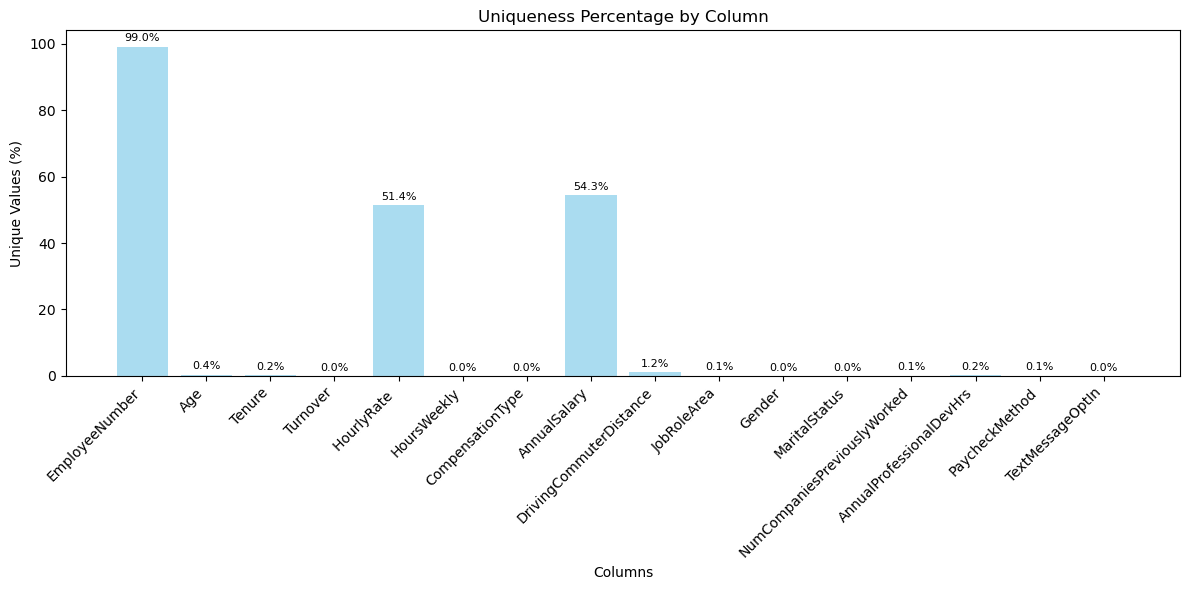


2. CHECKING MISSING VALUES...
Total missing values: 4,900 (3.00% of all data)
  Columns with missing values:
      â€¢ TextMessageOptIn: 2,266 (22.22%)
      â€¢ AnnualProfessionalDevHrs: 1,969 (19.31%)
      â€¢ NumCompaniesPreviouslyWorked: 665 (6.52%)



 3. CHECKING INCONSISTENT ENTRIES...
        Found 2 standardization groups in 'JobRoleArea':
         â€¢ information technology: 'Information_Technology' (56), 'Information Technology' (857) | Total: 913
         â€¢ human resources: 'Human_Resources' (41), 'Human Resources' (909) | Total: 950
        Found 2 standardization groups in 'PaycheckMethod':
         â€¢ mail check: 'Mail Check' (4986), 'Mail_Check' (547) | Total: 5533
         â€¢ direct deposit: 'Direct_Deposit' (958), 'Direct Deposit' (226) | Total: 1184
     Inconsistency issues found: 5260
    Columns with inconsistencies:
      â€¢ HourlyRate : whitespace_issues
      â€¢ JobRoleArea: standardization_issues, similar_values
        â†’ 2 standardization groups affecting 4 unique values
      â€¢ Gender: similar_values
      â€¢ PaycheckMethod: standardization_issues, similar_values
        â†’ 2 standardization groups affecting 4 unique values

 4. CHECKING FORMATTING ERRORS...
         Data Type Mismatch detected in

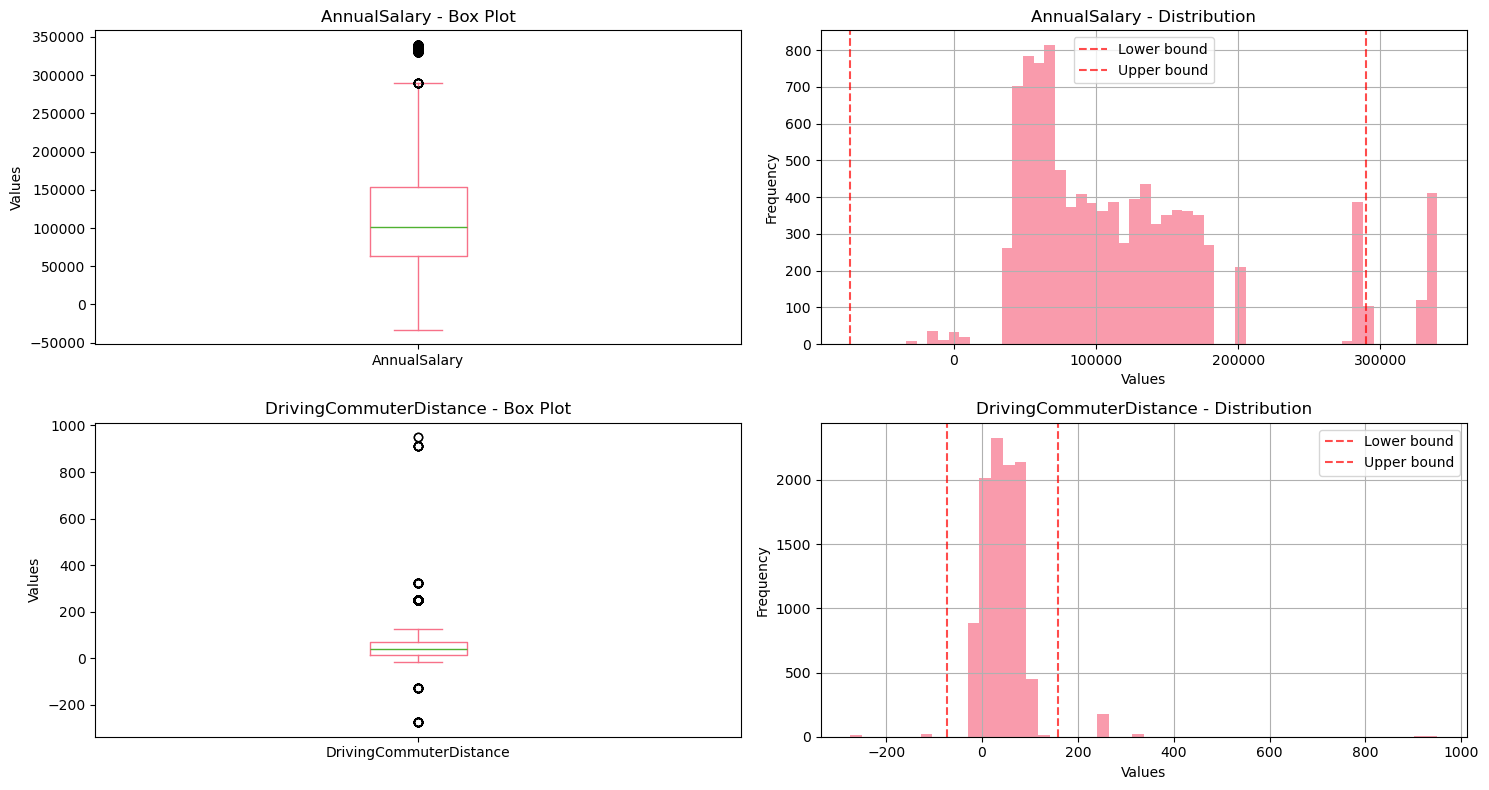

    Columns with outliers:
      â€¢ AnnualSalary: 544 outliers (5.33%)
      â€¢ DrivingCommuterDistance: 245 outliers (2.40%)

 GENERATING SUMMARY...

DATA QUALITY INSPECTION SUMMARY
Data Quality Score: 93.2/100
Total Issues Found: 11,049
Dataset Size: 10,199 rows Ã— 16 columns
Memory Usage: 5.51 MB

Issue Categories Found:
   â€¢ Duplicates
   â€¢ Missing Values
   â€¢ Inconsistent Entries
   â€¢ Formatting Errors
   â€¢ Outliers

Recommendations:
   Remove duplicate rows to improve data integrity
   Handle missing values through imputation or removal
   Standardize categorical values and fix case/whitespace issues
   Clean formatting errors and ensure consistent data types
   Investigate outliers - validate if they're errors or legitimate extreme values

Data quality inspection completed!


In [12]:
# Step 1: Run main quality check
main_report = quick_quality_check('Employee Turnover Dataset.csv')

In [14]:
# Step 1.5: Generate summary table of ORIGINAL data quality issues
print("\n" + "="*60)
print("GENERATING ORIGINAL DATA QUALITY SUMMARY")

summary_table = get_column_summary_table(df, main_report)
summary_table.to_csv('original_data_quality_summary.csv', index=False)
print("Original data quality summary exported to 'original_data_quality_summary.csv'")


GENERATING ORIGINAL DATA QUALITY SUMMARY
Original data quality summary exported to 'original_data_quality_summary.csv'


In [17]:
# Step 2: Run salary math validation  
print("\n" + "="*60)
salary_report = inspect_salary_math_consistency(df, tolerance_percentage=10.0)
# Step 3: Add flags to dataset
df_flagged = add_salary_consistency_flags(df, salary_report)


SALARY MATH CONSISTENCY INSPECTION
Using columns: HourlyRate , HoursWeekly, AnnualSalary
Tolerance: Â±10.0%
Work weeks per year: 52.0
Cleaning HourlyRate  column (removing currency symbols)...
Converted 10199 hourly rate values to numeric

 DATA OVERVIEW:
   Total records: 10,199
   Complete salary data: 10,142
   Incomplete/invalid: 57

MATH CONSISTENCY RESULTS:
  Consistent records: 8,801 (86.8%)
  Inconsistent records: 1,341 (13.2%)

 INCONSISTENCY SEVERITY:
   Minor (10-25%): 51 records
   Moderate (25-50%): 208 records
   Major (50-100%): 1,082 records

 INCONSISTENCY PATTERNS:
   Low Annual + High Hourly + Full Time: 52 records
   Possible Monthly Salary Error: 12 records

INCONSISTENCY STATISTICS:
Average difference: 58.6% ($-87,654)
Median difference: 55.1% ($-100,000)
Maximum difference: 96.9%

TOP 10 WORST INCONSISTENCIES:
--------------------------------------------------------------------------------
 1. Row 3341: $20.34/hr Ã— 40hr/wk = $42,307/yr BUT shows $1,307/yr (96.9

In [19]:
# Step 3.5: DATA CLEANING PROCESS
print("\n" + "="*60)
print("STARTING DATA CLEANING PROCESS")

df_cleaned = clean_employee_data(df_flagged, report=main_report, backup=True)
df_processed = handle_outliers_and_absurd_values(df_cleaned, method='flag')

# Export additional Cleaning Report
cleaned_report = inspect_data_quality(df_processed, show_plots=False)
summary_table_after = get_column_summary_table(df_processed, cleaned_report)
summary_table_after.to_csv('data_quality_AFTER_cleaning.csv', index=False)

# Step 4: Export final files
flagged_records = df_processed[df_processed['Salary_Needs_Review'] == True]
flagged_records.to_csv('salary_math_inconsistencies_for_review.csv', index=False)
df_processed.to_csv('Employee_Turnover_Dataset_CLEANED.csv', index=False)
outlier_investigation_df = create_outlier_investigation_report(df_processed, 'outlier_investigation_report.csv')

print(f"\nExported {len(flagged_records)} problematic salary records for evaluation")
print(f"Exported cleaned dataset with {len(df_processed)} records")


STARTING DATA CLEANING PROCESS
STARTING DATA CLEANING PROCESS
 Original data backed up

 1. REMOVING DUPLICATE ROWS...
Removed 99 duplicate rows

 2. FIXING DATA TYPE MISMATCHES...
   Cleaning HourlyRate column...
   Converted 10100 HourlyRate values to numeric

 3. STANDARDIZING CATEGORICAL VALUES...
   Standardizing PaycheckMethod...
     Standardized PaycheckMethod: 7 â†’ 2 unique values
   Standardizing JobRoleArea...
   âœ“ Standardized JobRoleArea: 12 â†’ 8 unique values

 4. CLEANING WHITESPACE ISSUES...
   No whitespace issues found

 5. HANDLING ABSURD VALUES...
   Removing 53 negative salary values...
    Removed 53 impossible negative salaries
   Handling 1334 negative commute distances...
    Set 1334 negative distances to NaN for review

 5.5. CONVERTING HIDDEN MISSING VALUES...
    No 'N/A' strings found
   Hidden missing value conversion completed

 6. HANDLING MISSING VALUES...
   Imputing 1334 missing values in DrivingCommuterDistance using median...
   âœ“ Imputed 13

In [ ]:

# Export additional Cleaning Report
cleaned_report = inspect_data_quality(df_processed, show_plots=False)
summary_table_after = get_column_summary_table(df_processed, cleaned_report)
summary_table_after.to_csv('data_quality_AFTER_cleaning.csv', index=False)

# Step 4: Export final files
flagged_records = df_processed[df_processed['Salary_Needs_Review'] == True]
flagged_records.to_csv('salary_math_inconsistencies_for_review.csv', index=False)
df_processed.to_csv('Employee_Turnover_Dataset_CLEANED.csv', index=False)
outlier_investigation_df = create_outlier_investigation_report(df_processed, 'outlier_investigation_report.csv')

print(f"\nExported {len(flagged_records)} problematic salary records for evaluation")
print(f"Exported cleaned dataset with {len(df_processed)} records")